In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from torchvision import transforms
import torch.nn.functional as F
import pandas as pd
from collections import OrderedDict
import cv2

sys.path.append('./')
from modules.model import Model
from modules.utils import CTCLabelConverter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [2]:
class NepaliTextRecognitionConfig:
    def __init__(self):
        self.number = '०१२३४५६७८९0123456789'
        self.symbol = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{}~।॥—‘’“”… "
        self.lang_char = 'अआइईउऊऋएऐओऔअंअःकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहक्षत्रज्ञािीुूृेैोौंःँॅॉ'
        
        self.character = self.number + self.symbol + self.lang_char
        print(f"Total characters: {len(self.character)}")
        print(f"Numbers: {self.number}")
        print(f"Language characters sample: {self.lang_char}...")
        
        self.Transformation = 'None'
        self.FeatureExtraction = 'ResNet'
        self.SequenceModeling = 'BiLSTM'
        self.Prediction = 'CTC'
        
        self.imgH = 80  
        self.imgW = 1220
        self.input_channel = 3
        self.output_channel = 256
        self.hidden_size = 256
        self.num_fiducial = 20
        
        self.batch_max_length = 150
        self.sensitive = True
        self.PAD = False
        self.rgb = True
        self.contrast_adjust = False
        
        self.decode = 'beamsearch' #beam search
        self.num_class = len(self.character)

def print_character_set(config):
    print("Character Set Analysis:")
    print(f"Total unique characters: {len(config.character)}")
    print(f"Numbers: {len(config.number)} characters")
    print(f"Symbols: {len(config.symbol)} characters") 
    print(f"Language characters: {len(config.lang_char)} characters")

config = NepaliTextRecognitionConfig()
print_character_set(config)

Total characters: 132
Numbers: ०१२३४५६७८९0123456789
Language characters sample: अआइईउऊऋएऐओऔअंअःकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसहक्षत्रज्ञािीुूृेैोौंःँॅॉ...
Character Set Analysis:
Total unique characters: 132
Numbers: 20 characters
Symbols: 40 characters
Language characters: 72 characters


In [7]:
def load_crnn_model(model_path, config):
    
    converter = CTCLabelConverter(config.character)
    config.num_class = len(converter.character)
    
    # print(f"Model Configuration:")
    # print(f"  Input size: {config.imgH}x{config.imgW}")
    # print(f"  Input channels: {config.input_channel}")
    # print(f"  Number of classes: {config.num_class}")
    # print(f"  Transformation: {config.Transformation}")
    # print(f"  Feature Extraction: {config.FeatureExtraction}")
    # print(f"  Sequence Modeling: {config.SequenceModeling}")
    # print(f"  Prediction: {config.Prediction}")
    
    model = Model(config)
    
    if os.path.exists(model_path):
        #print(f"Loading model from: {model_path}")
        state_dict = torch.load(model_path, map_location=device)
        
        if isinstance(state_dict, dict) and 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        
        if all(key.startswith('module.') for key in state_dict.keys()):
            new_state_dict = OrderedDict()
            for k, v in state_dict.items():
                name = k[7:]
                new_state_dict[name] = v
            state_dict = new_state_dict
        try:
            model.load_state_dict(state_dict)
            #print("✓ Model loaded successfully!")
        except Exception as e:
            print(f"Error loading state dict: {e}")
            print("Trying to load with strict=False...")
            model.load_state_dict(state_dict, strict=False)
            print("✓ Model loaded with strict=False")
            
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    model = model.to(device)
    model.eval()
    
    return model, converter

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# def center_and_resize_image(img, target_size=(1156, 64), input_channels=1):
#     """
#     Resize the image to fit inside target_size while maintaining aspect ratio.
#     If the image is smaller, center it on a black background of target_size.
#     Handles both grayscale and RGB images based on input_channels.
    
#     Args:
#         img: PIL Image or path to image
#         target_size: (width, height) tuple for output size
#         input_channels: 1 for grayscale, 3 for RGB
    
#     Returns:
#         Preprocessed PIL Image
#     """
#     target_w, target_h = target_size
    
#     if isinstance(img, str):
#         img = Image.open(img)
    
#     if input_channels == 1:
#         # Convert to grayscale
#         if img.mode != 'L':
#             img = img.convert('L')
#         background_color = 0  # black for grayscale
#     elif input_channels == 3:
#         if img.mode != 'RGB':
#             img = img.convert('RGB')
#         background_color = (0, 0, 0)
#     else:
#         raise ValueError("input_channels must be 1 (grayscale) or 3 (RGB)")
    
#     img_w, img_h = img.size

#     if img_w > target_w or img_h > target_h:
#         img.thumbnail((target_w, target_h), Image.LANCZOS)

#     if input_channels == 1:
#         new_img = Image.new("L", (target_w, target_h), color=background_color)
#     else:
#         new_img = Image.new("RGB", (target_w, target_h), color=background_color)

#     paste_x = (target_w - img.width) // 2
#     paste_y = (target_h - img.height) // 2
#     new_img.paste(img, (paste_x, paste_y))

#     return new_img


def center_and_resize_image(img, target_size=(1220, 80)):
    """
    Resize the image to fit inside target_size while maintaining aspect ratio.
    If the image is smaller, center it on a black background of target_size.
    """
    if isinstance(img, str):
       img = Image.open(img)
    target_w, target_h = target_size
    img_w, img_h = img.size

    if img_w > target_w or img_h > target_h:
        img.thumbnail((target_w, target_h), Image.LANCZOS)
    new_img = Image.new("RGB", (target_w, target_h), color="black")
    paste_x = (target_w - img.width) // 2
    paste_y = (target_h - img.height) // 2
    new_img.paste(img, (paste_x, paste_y))

    return new_img

def preprocess_crnn_image(image_path, config, return_tensor=True):
    """
    Complete preprocessing pipeline for the text recognition model.
    
    Args:
        image_path: Path to image or PIL Image
        config: Model configuration object
        return_tensor: Whether to return PyTorch tensor or PIL Image
    
    Returns:
        Preprocessed image tensor or PIL Image
    """
    input_channels = getattr(config, 'input_channel', 1)
    
    processed_pil = center_and_resize_image(image_path, (config.imgW, config.imgH))
    
    if not return_tensor:
        return processed_pil
    
    image_np = np.array(processed_pil)
    
    image_np = image_np.astype(np.float32) / 255.0
    
    if getattr(config, 'contrast_adjust', False):
        image_np = (image_np - np.mean(image_np)) / (np.std(image_np) + 1e-8)
    
    if input_channels == 1:
        image_tensor = torch.from_numpy(image_np).unsqueeze(0) 
        image_tensor = (image_tensor - 0.5) / 0.5
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image_tensor = transform(processed_pil)
    
    # Add batch dimension: (1, C, H, W)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

def visualize_crnn_preprocessing(image_path, config):

    """Visualize the original and preprocessed image for text"""
    
    original_image = Image.open(image_path)
    if config.rgb:
        original_image = original_image.convert('RGB')
    else:
        original_image = original_image.convert('L')
    
    processed_tensor = preprocess_crnn_image(image_path, config)
    processed_image = processed_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    if config.rgb:
        # Denormalize for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        processed_image = processed_image * std + mean
        processed_image = np.clip(processed_image, 0, 1)
    else:
        processed_image = (processed_image * 0.5) + 0.5
        processed_image = np.clip(processed_image, 0, 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original image
    axes[0].imshow(original_image, cmap='gray' if not config.rgb else None)
    axes[0].set_title(f'Original Image\nSize: {original_image.size}')
    axes[0].axis('off')
    
    # Processed image
    if config.rgb:
        axes[1].imshow(processed_image)
    else:
        axes[1].imshow(processed_image[:, :, 0], cmap='gray')
    axes[1].set_title(f'Preprocessed Image\nSize: {config.imgW}x{config.imgH}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    #print(f"Original image size: {original_image.size}")
    #print(f"Processed tensor shape: {processed_tensor.shape}")

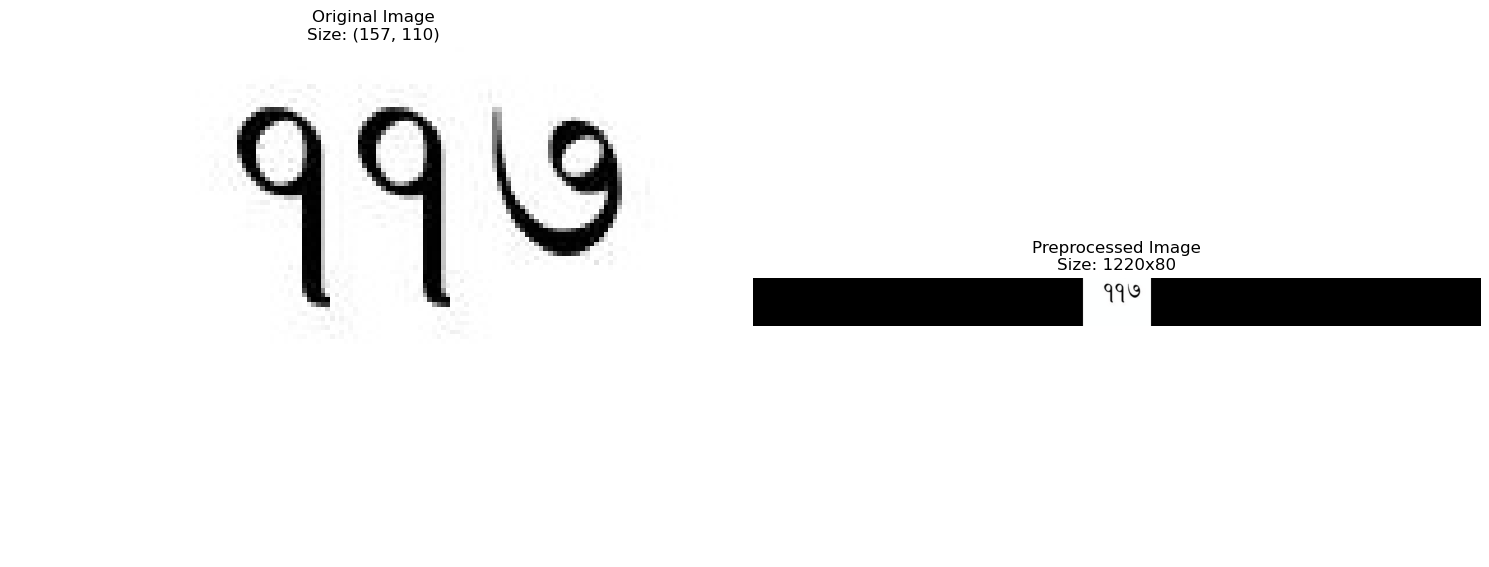

No Transformation module specified


/tmp/ipykernel_253291/3992349709.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


['११७']


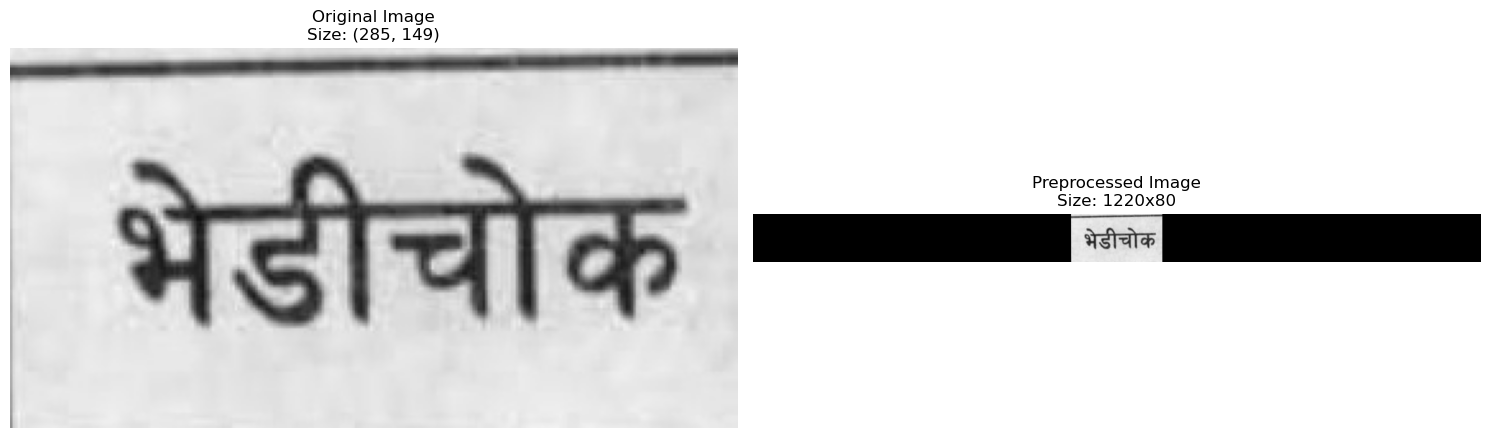

No Transformation module specified
['भेडीचोक']


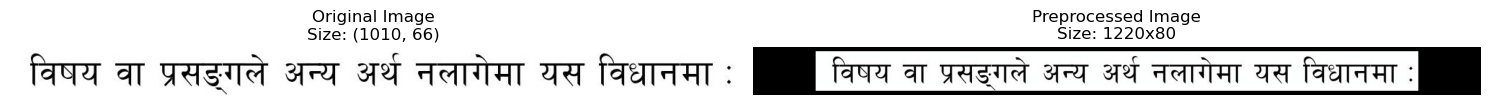

No Transformation module specified
['विषय वा प्रसड.गले अन्य अर्थ नलागेमा यस विधानमा :']


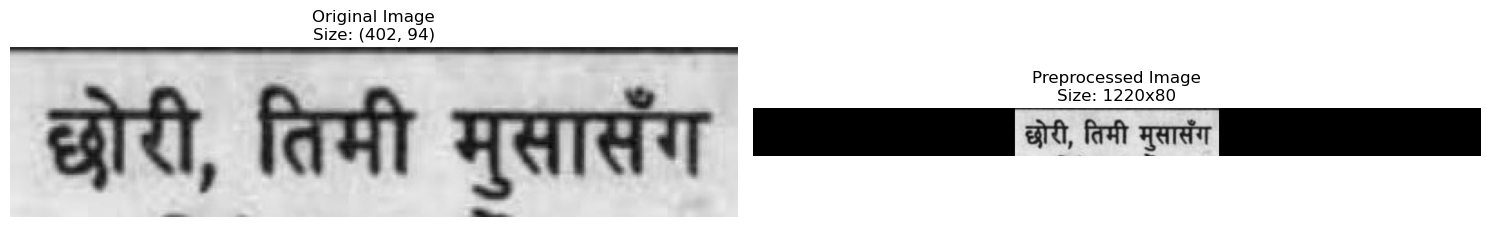

No Transformation module specified
['"छोरी, तिमी मुसासँग"']


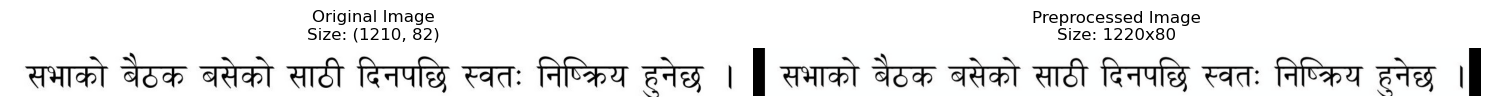

No Transformation module specified
['‘सभाको बैठक बसेको साठी दिनपछि स्वत: निष्क्रिय हनेछ ।१']


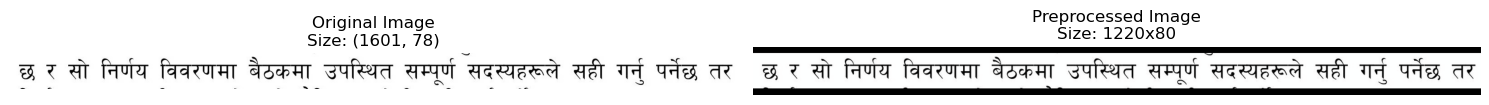

No Transformation module specified
['छ र सो निर्णय विवरणमा बैठकमा उपस्थित सम्पूर्ण सदस्यहरूले सही गर्नु पर्नेछ तर']


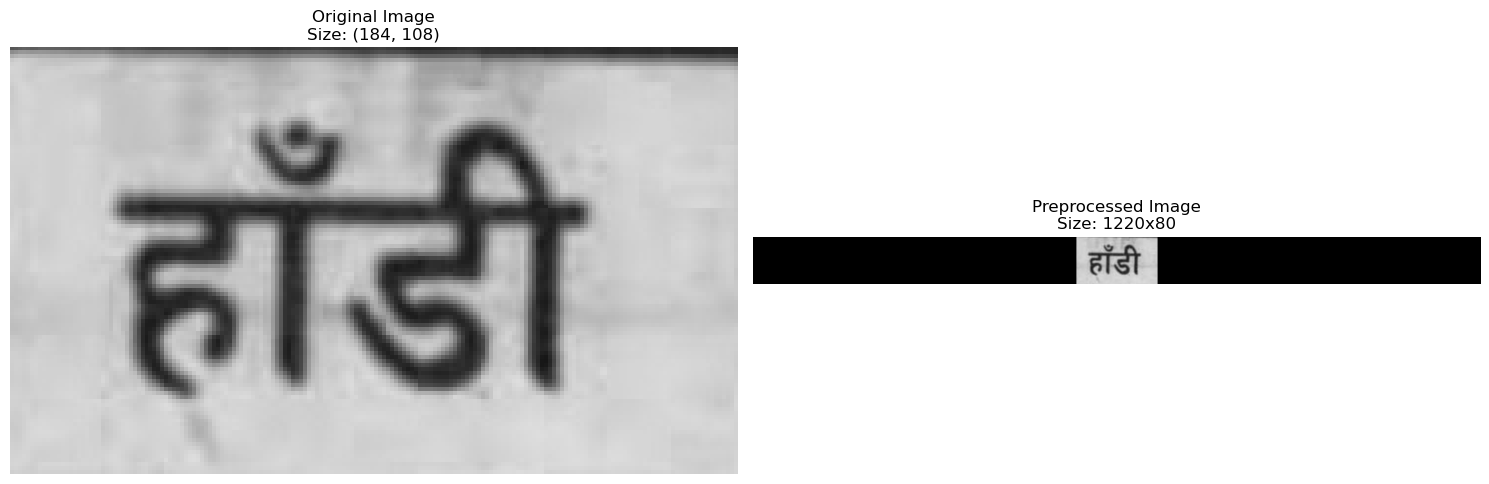

No Transformation module specified
['हाँडी']


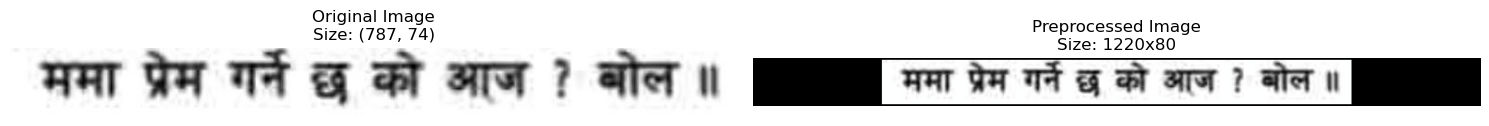

No Transformation module specified
['ममा प्रेम गर्ने छ को आज ? बोल ॥']


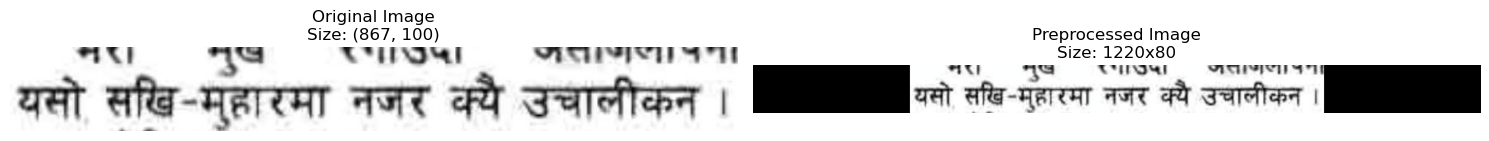

No Transformation module specified
['यसो ्सखि-मुहारमा नजर क्यै उचालीकन ।']


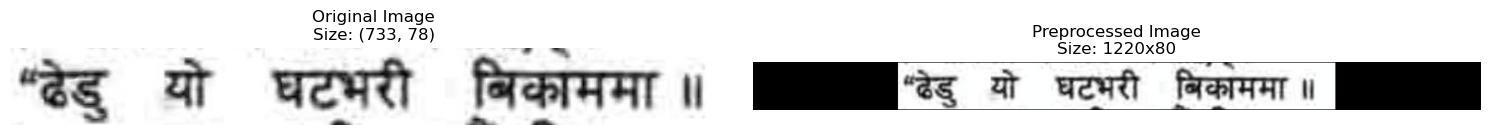

No Transformation module specified
['#देडु यो घरशभरी बिकमोममा ॥']


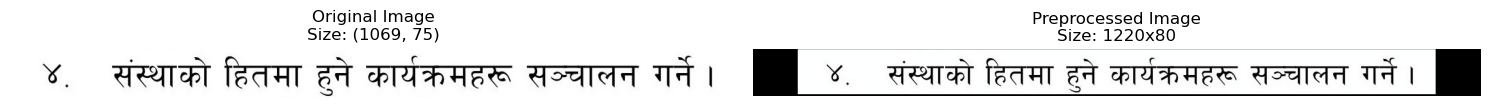

No Transformation module specified
['४. संस्थाको हितमा हुने कार्यक्रमहरू सञ्चालन गर्ने ।']


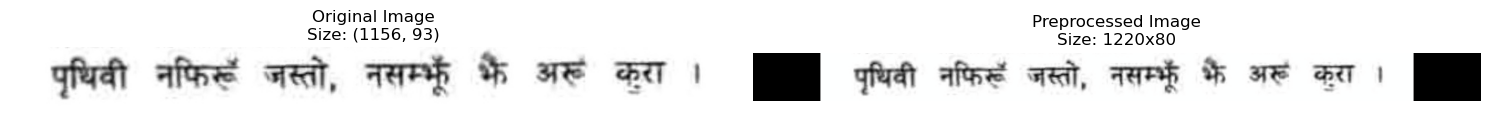

No Transformation module specified
['"पृथिवी नफिरूँ जस्तो, नसम्भूँ #ै अरूै कुरा 1"']


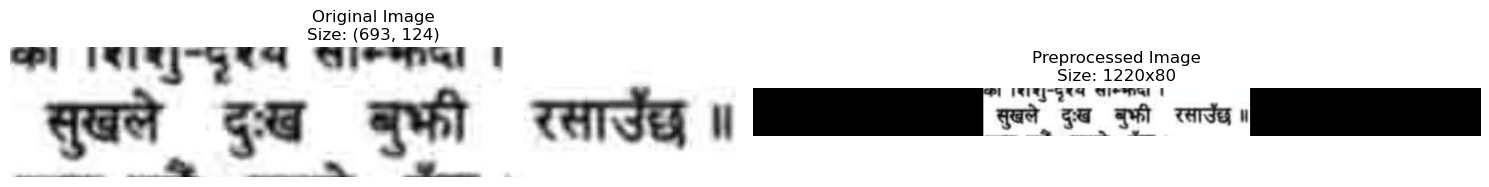

No Transformation module specified
['पसुषलेु दुःख  बुभुी रसाउँैछ ।।']


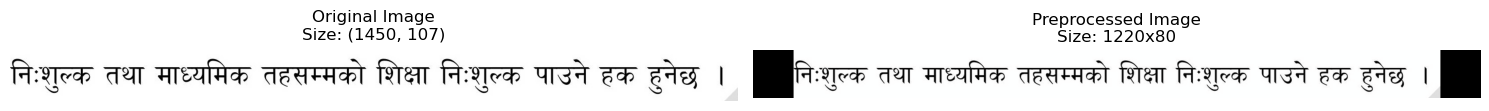

No Transformation module specified
['नि:शुल्क तथा माध्यमिक तहसम्मको शिक्षा नि:शुल्क पाउने हक हुनेछ ।']


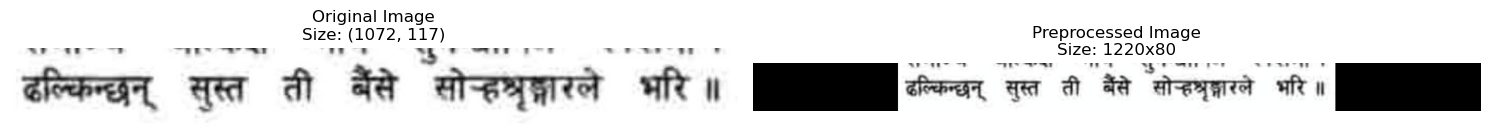

No Transformation module specified
['हल्किन्छन् सुस्त ती बैसे सोज्हश्रङ्गारले भरि ।।']


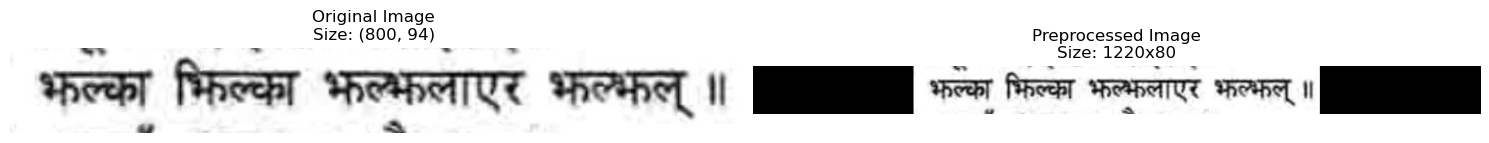

No Transformation module specified
['+भल्का भिल्कका भल्लाएर भल्भल् ।।']


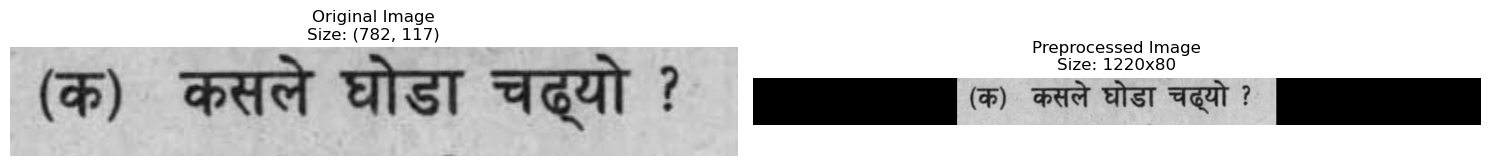

No Transformation module specified
['(क) कसले घोडा चदढ्यो ?']


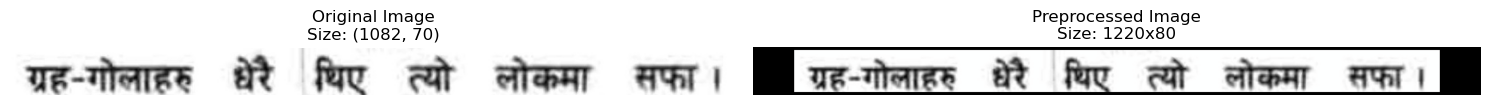

No Transformation module specified
['गह-गोलाहरुू धेरै थिए त्यो लोक्त्मा सेफा ।']


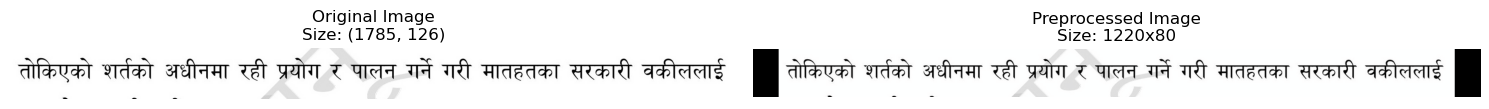

No Transformation module specified
['तोकिएको शर्तको अधीनमा रही प्रयोग-र पालन_ गर्ने गरी मातहतका सरकारी वकीललाई']


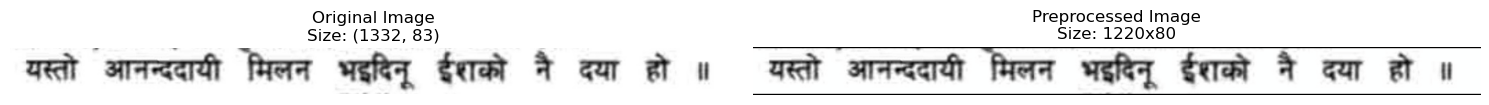

No Transformation module specified
['यस्तो आनन्ददायी मिलन भइदिनू ईँशको नै दया हो ।।']


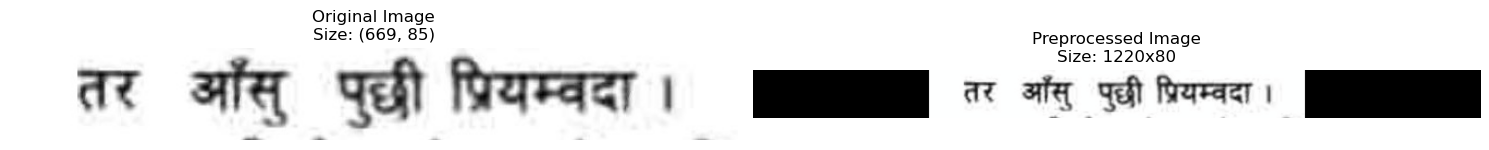

No Transformation module specified
['तर आँसु पुछी प्रियम्वदा ।']


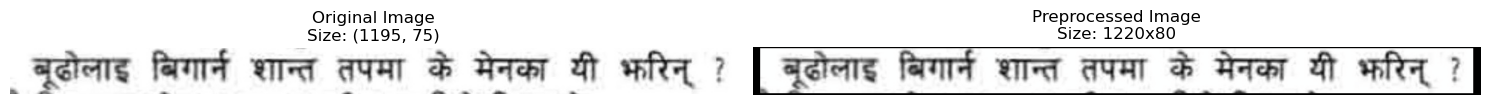

No Transformation module specified
['जुहोलाइ बिगार्ने शान्त तपमा के मेनका यी भरिन् ?']


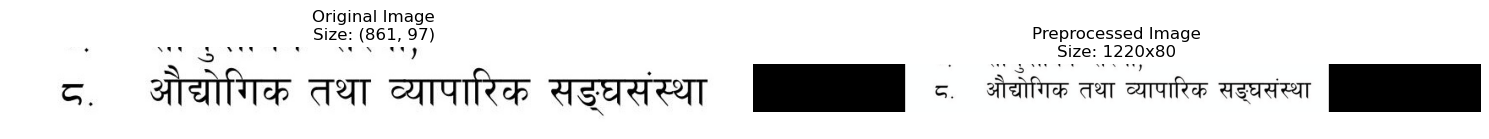

No Transformation module specified
['ड. औ्यगिक तथा व्यापारिक सङ्घसंस्था']


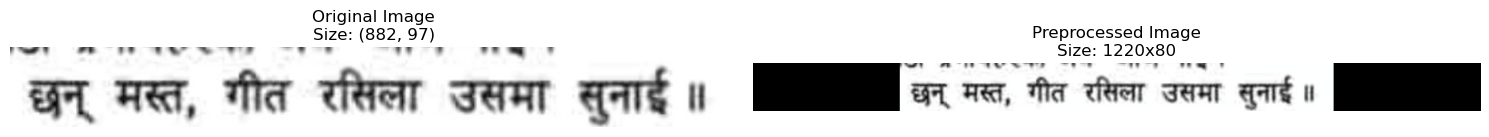

No Transformation module specified
['"छन् मस्त, गीत रसिला उसमा सुनाई ॥"']


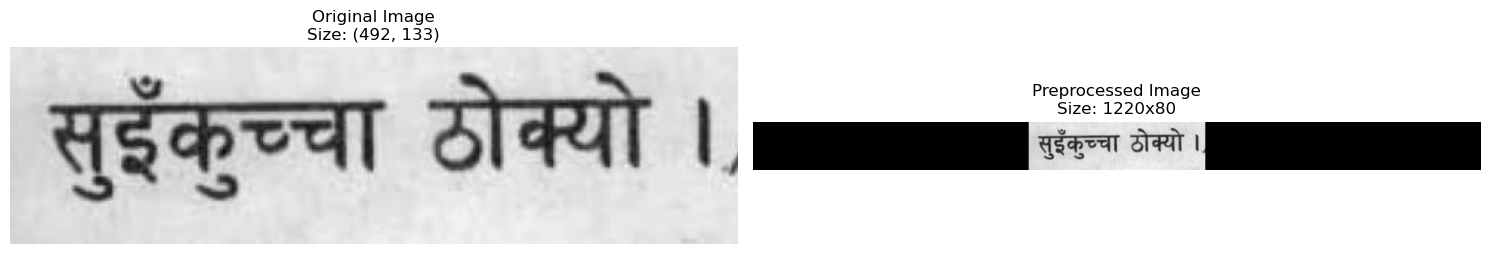

No Transformation module specified
['सुइँकुच्चा ठोक्यो ।']


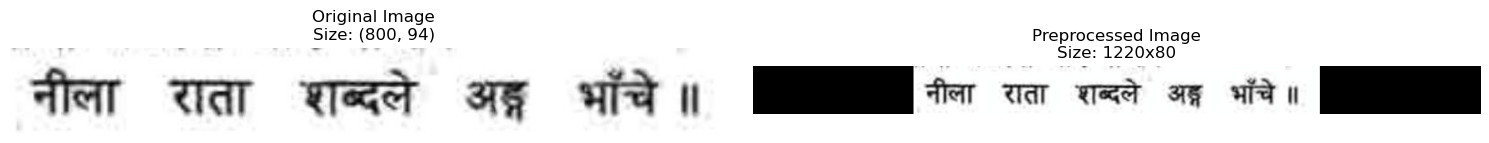

No Transformation module specified
['नीला राता शब्दले अड्ग भाँचे ॥']


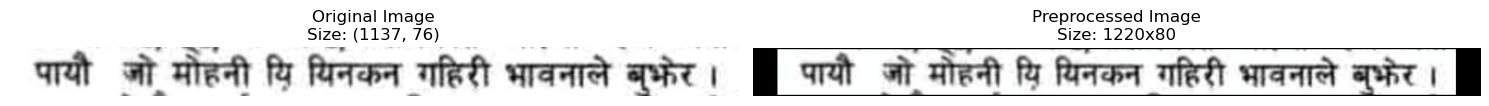

No Transformation module specified
['पायौ जो मोहनी थि यिनकन गहिरी भावनाले नुष्ेर ।']


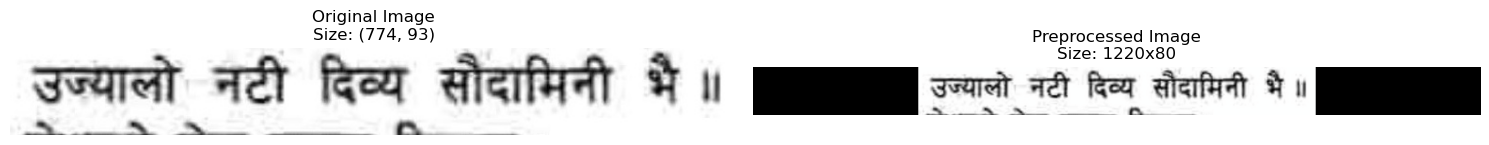

No Transformation module specified
['उज्यालो नटी दिव्य सौदामिनी भै ।']


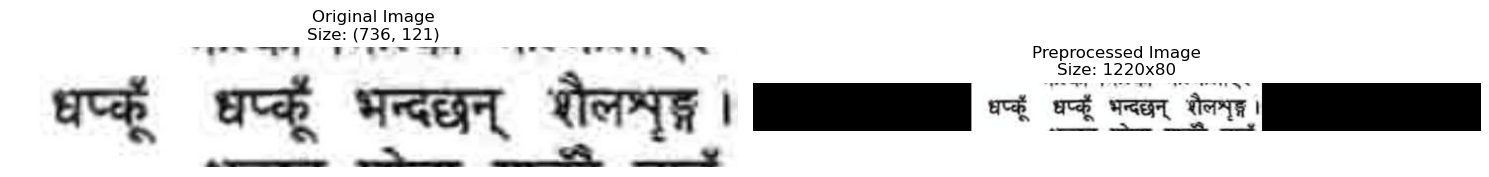

No Transformation module specified
['धप्कूँ धप्कूँ भन्दछन् शैलम्ृङ्ग ।']


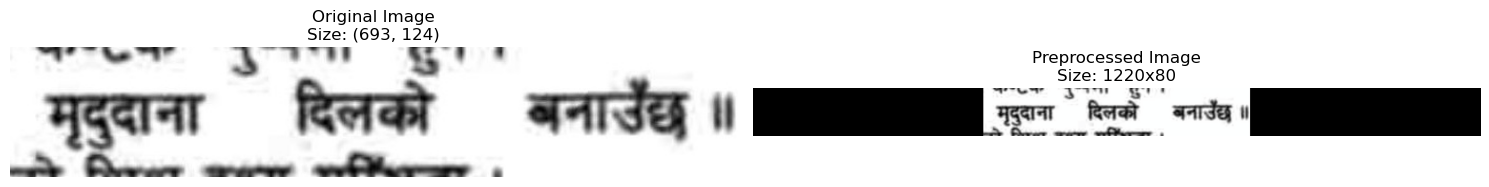

No Transformation module specified
['मदु्दाना लु दिनकोँ बनाउँछ ।।']


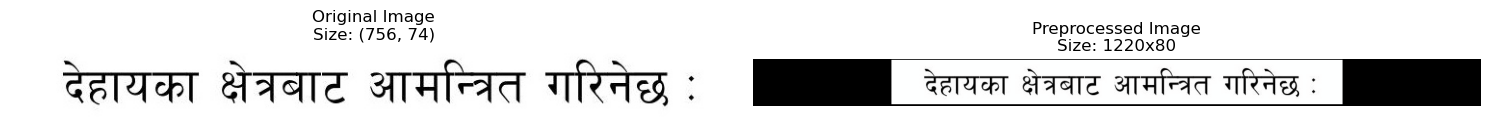

No Transformation module specified
['देहायका क्षेत्रबाट आमन्त्रित गरिनेछ :']


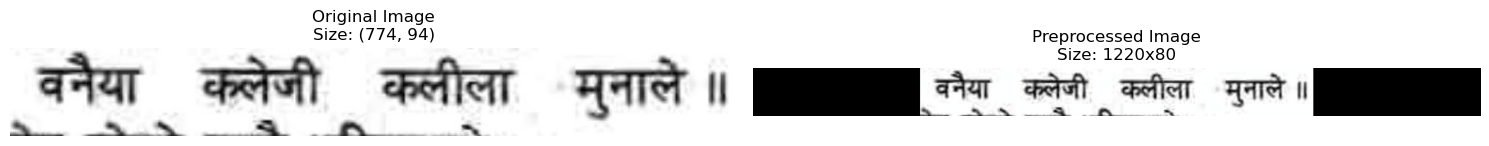

No Transformation module specified
['वनैया क्लेजी कलीला मुनाले ।।']


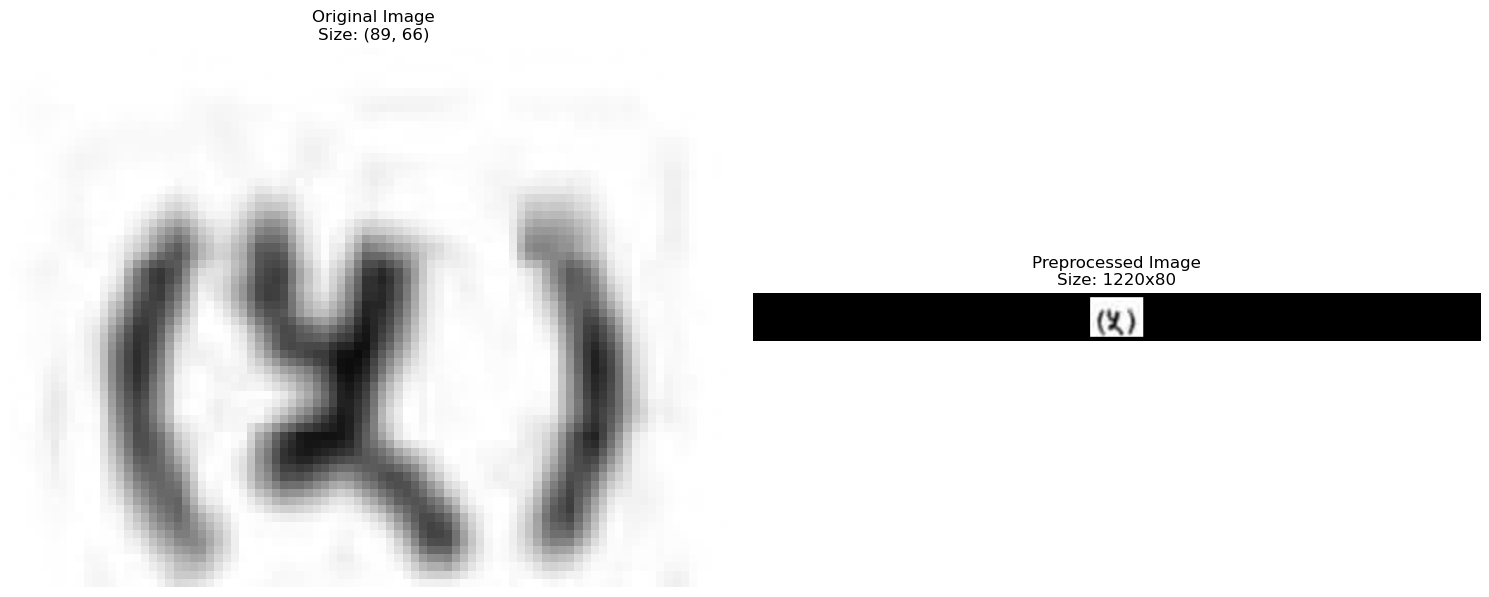

No Transformation module specified
['(५ू )']


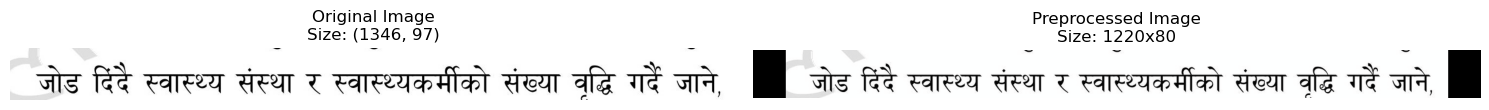

No Transformation module specified
['"जोड दिदै स्वास्थ्य संस्था र स्वास्थ्यकर्मीको संख्या वृद्धि गर्दै जाने,"']


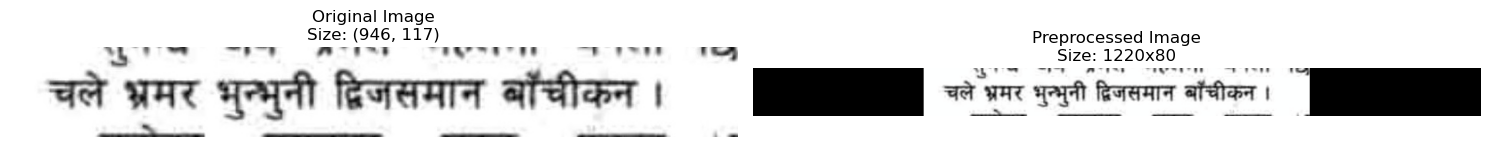

No Transformation module specified
['चले भ्रमर भुन्भुनी द्विजसमान बाँचीकन ।']


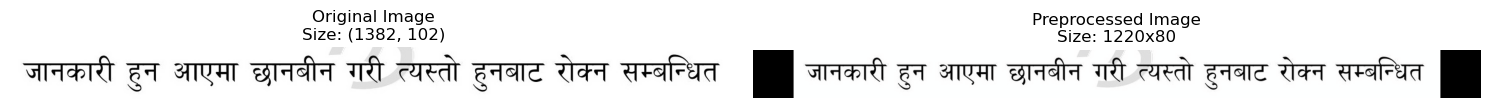

No Transformation module specified
['जानकारी हुन आएमा छानबीन गरी-त्यस्तो हुनबाट रोक्न सम्बन्धित']


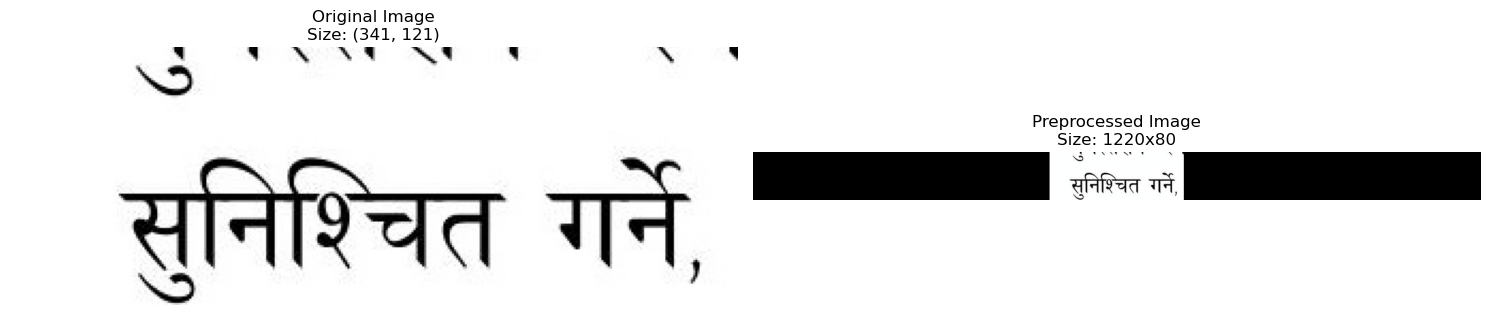

No Transformation module specified
['"सुनिश्चित गर्ने,"']


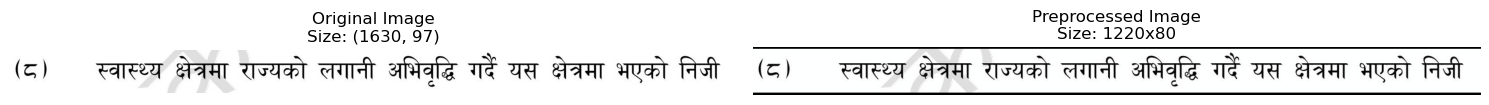

No Transformation module specified
['(छ) स्वास्थ्य क्षेत्रमा राज्यको लगानी अभिवृद्धि गर्दै यस क्षेत्रमा भएको निजी']


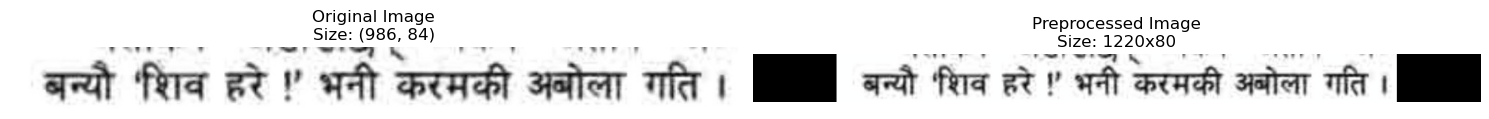

No Transformation module specified
["बन्यौ ‘शविाव हरे !' भनी करमकी अबोला गति ।"]


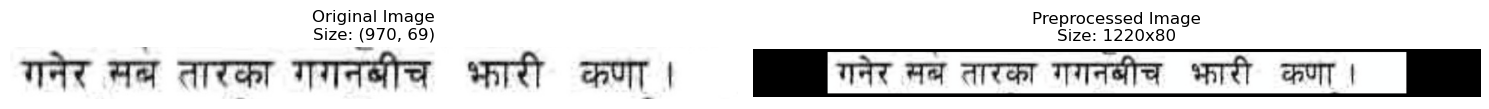

No Transformation module specified
['वानेर मन्ने तारका गग्रननीच फा-री कपा ।']


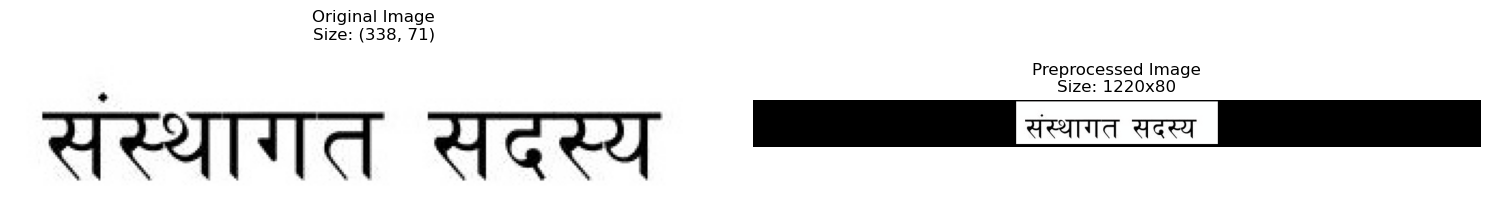

No Transformation module specified
['संस्थागत सदस्य']


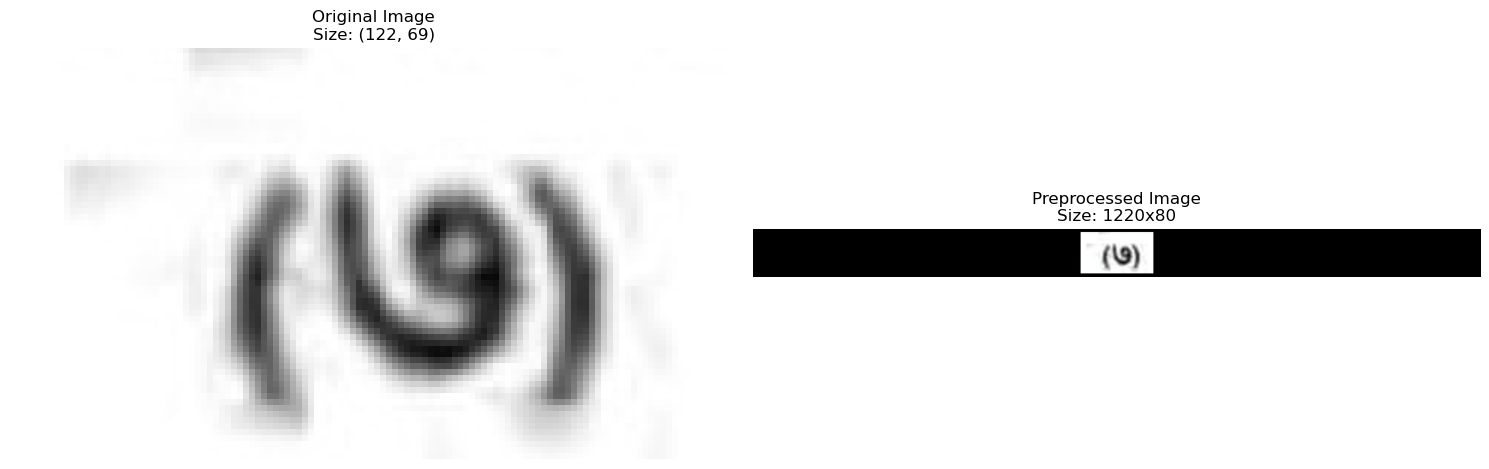

No Transformation module specified
['(७)']


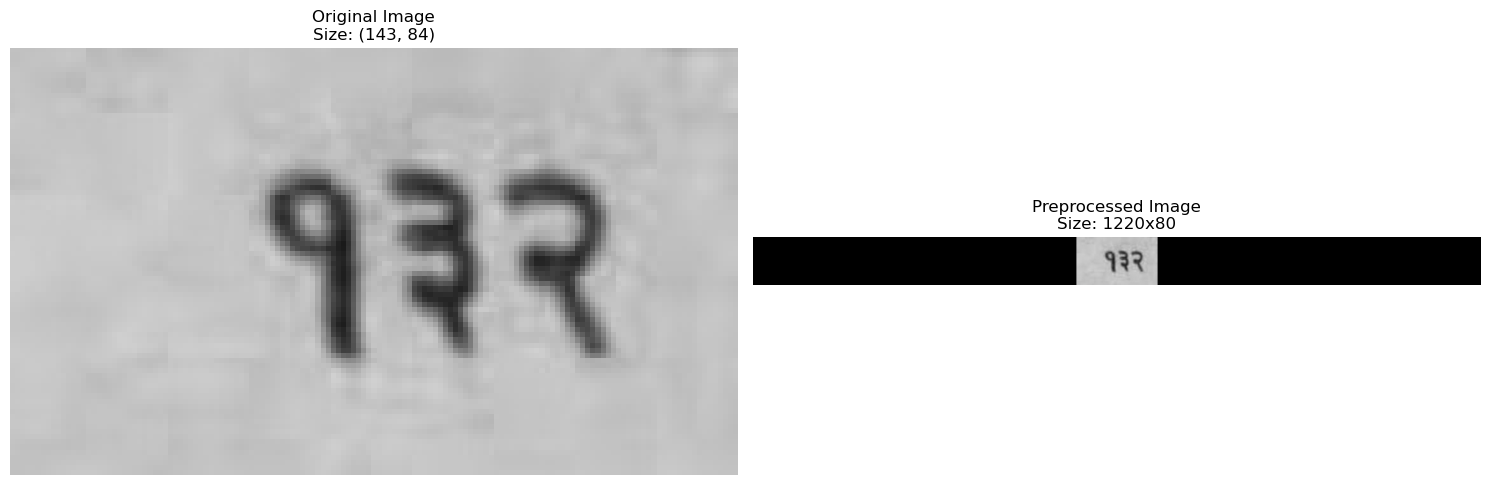

No Transformation module specified
['१३२']


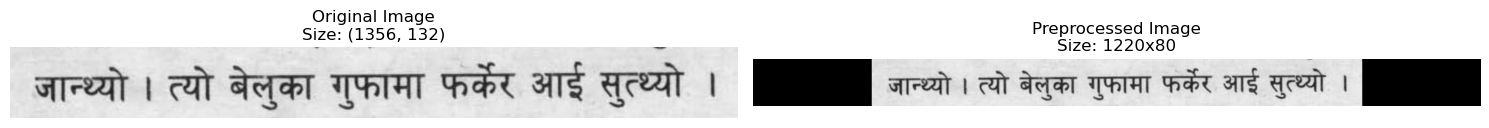

No Transformation module specified
['जान्थ्यो । त्यो बेलुका गुफामा फर्केर आई सुत्थ्यो ।']


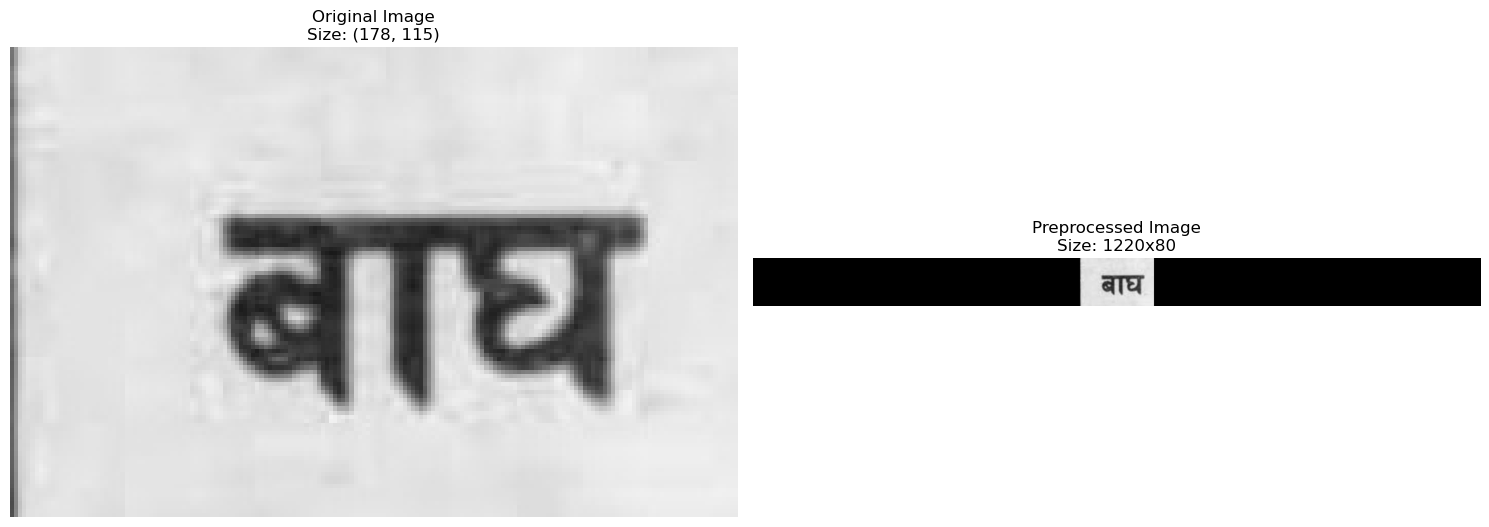

No Transformation module specified
['बाघ']


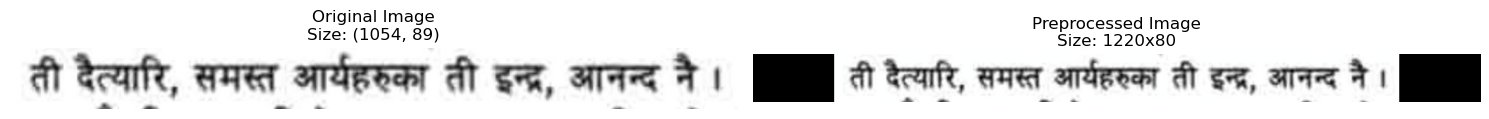

No Transformation module specified
['"ती दैल्यारि, समस्त आर्यहरुका ती इन्द्र, झनन्द नै ।"']


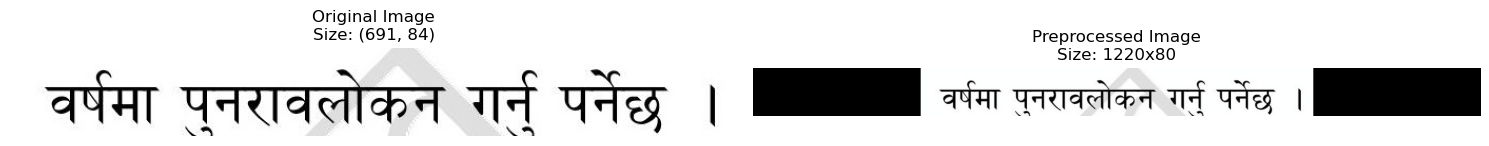

No Transformation module specified
['वर्षमा पनरावलोकन गर्न् पर्नेछ ।']


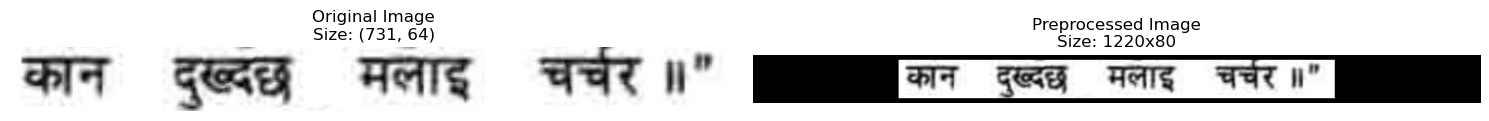

No Transformation module specified
['कान दुख्दछ मलाइ चर्खचेर ॥8']


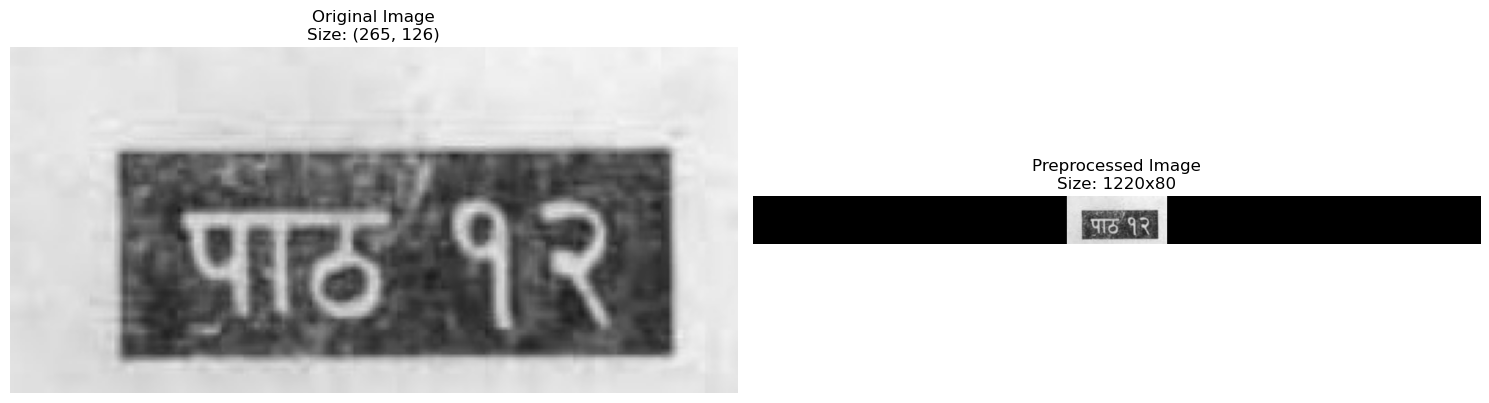

No Transformation module specified
['छ्ुटुडुूहुङ्नुूु:डहुड्ग्ी']


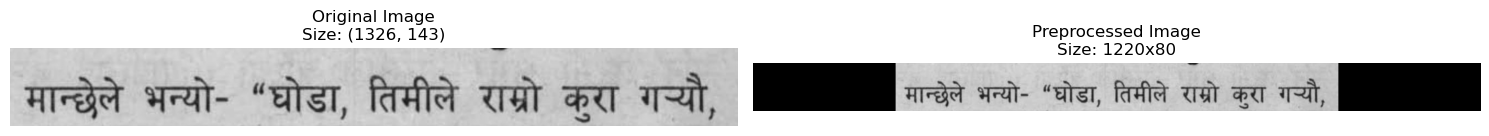

No Transformation module specified
['"मान्छेले भन्यो- “घोडा, तिमीले राम्रो कुरा गच्यौ,"']


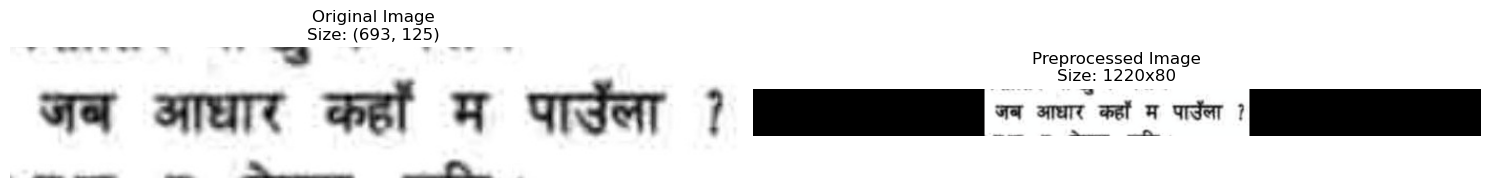

No Transformation module specified
['जब आधार कहाँ म पाउँला ?']


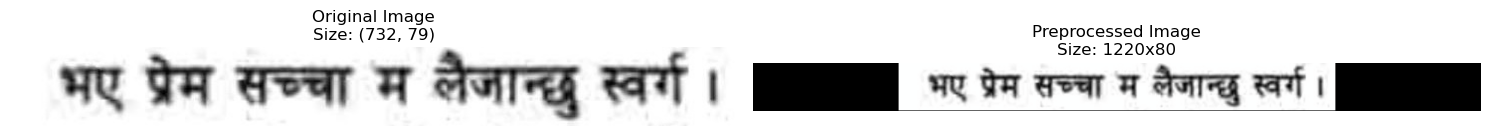

No Transformation module specified
['भए प्रेम सच्त्चा म लैजान्छु स्वर्रय ।']


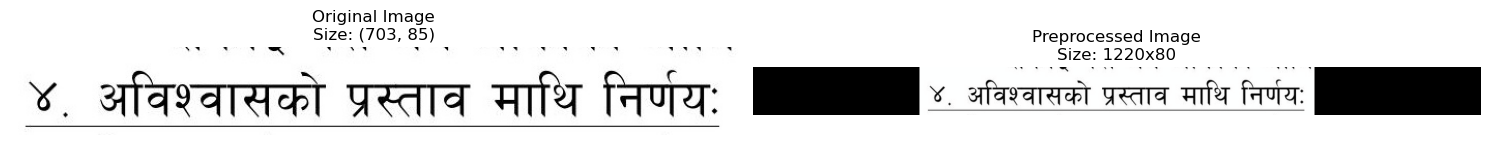

No Transformation module specified
['४. अविश्वासको प्रस्ताव माथि निर्णय:']


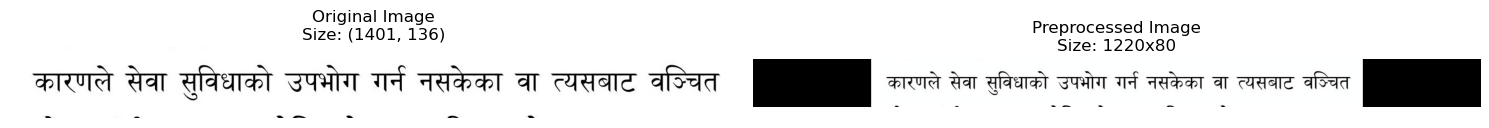

No Transformation module specified
['कारणले सेवा सुविधाको उपभोग गर्न नसकेका वा त्यसबाट वञ्चित']


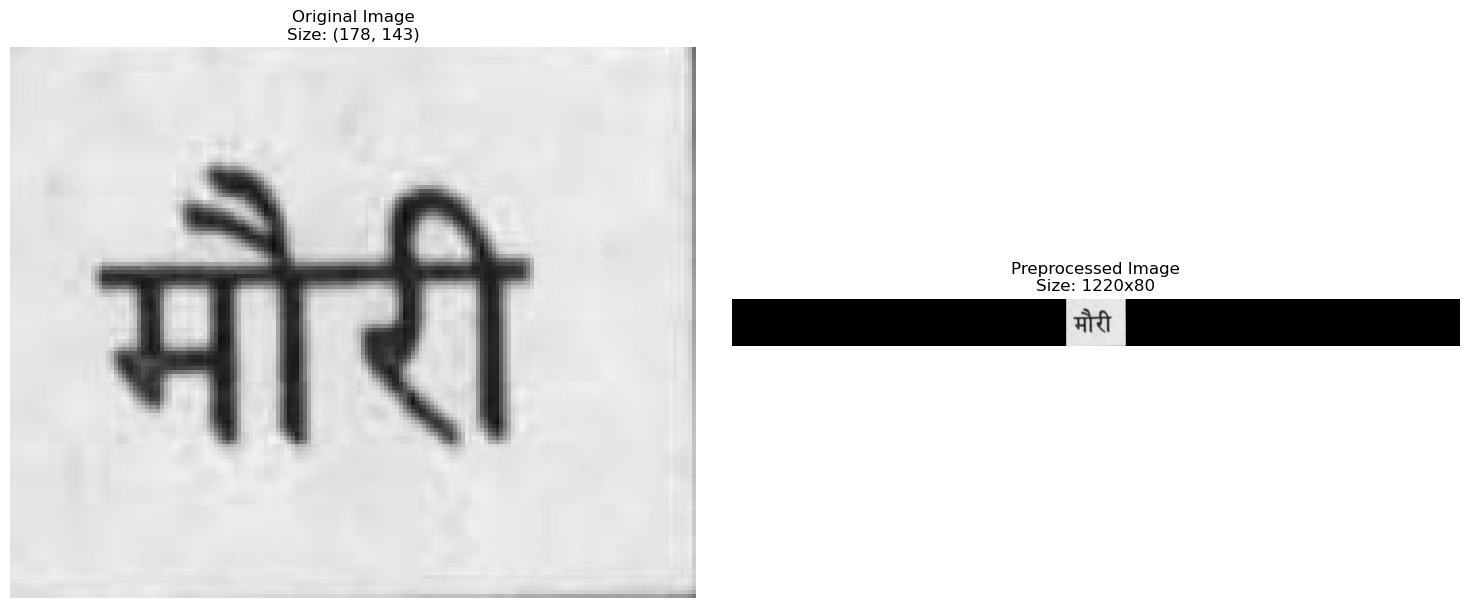

No Transformation module specified
['मौरी']


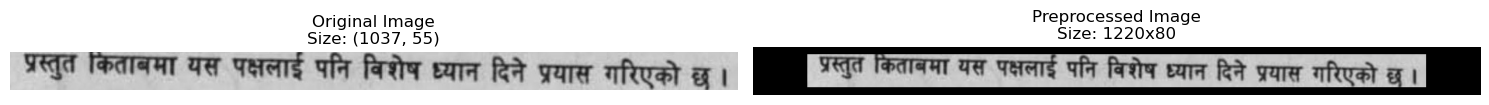

No Transformation module specified
['प्रस्तुत किताबमा यस पक्षलाई पनि विशेष ध्यान दिने प्रयास गरिएको छ ।']


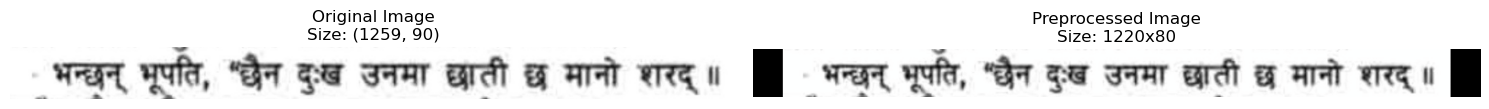

No Transformation module specified
['"भन्छन् भूपति, ‘छैन दुःज उनमा छाती छ मानो शरद् ।।"']


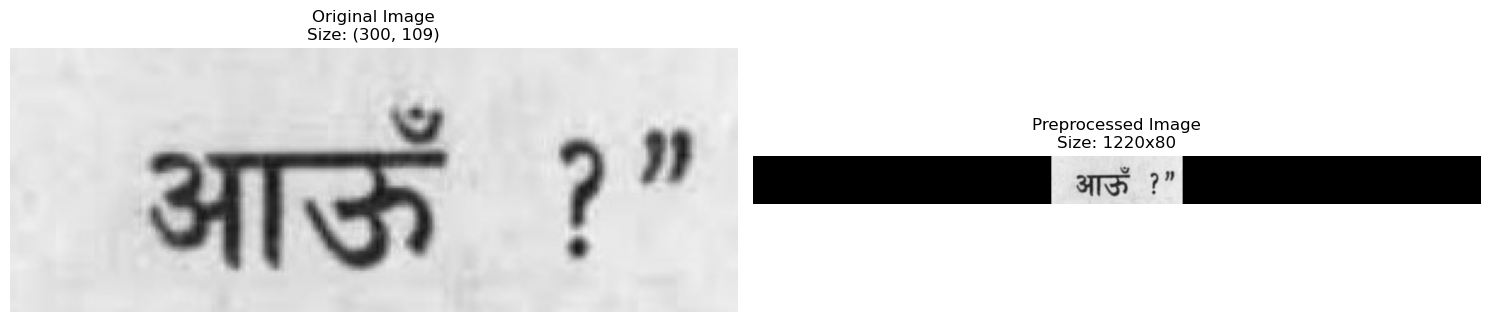

No Transformation module specified
['आजऊँ ?”']


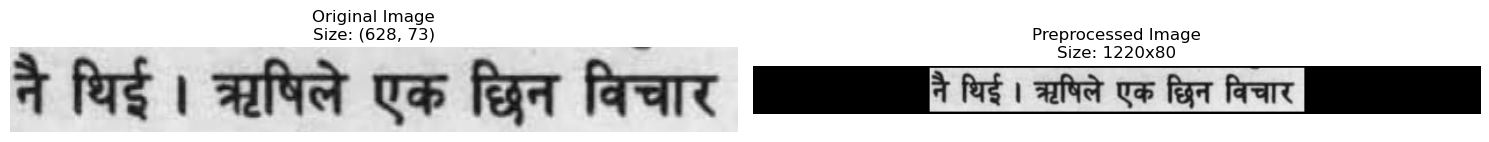

No Transformation module specified
['नै थिई । न्ृषिले एक छिन विचार']


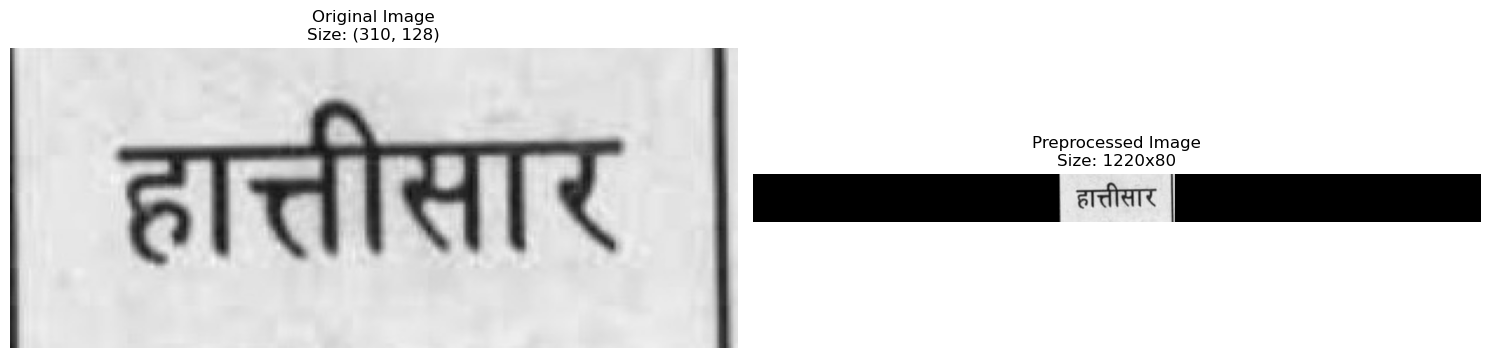

No Transformation module specified
['हात्तीसार ।']


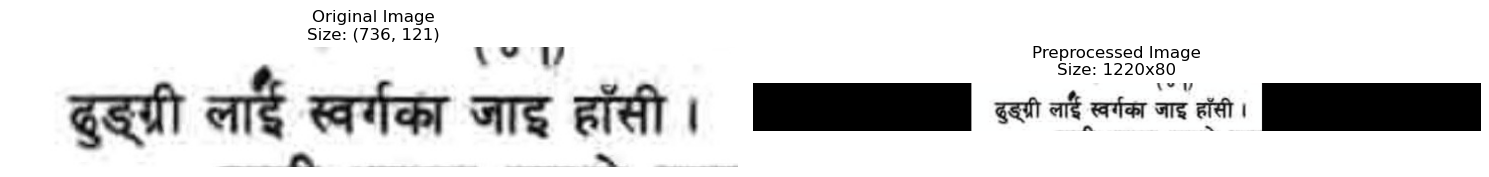

No Transformation module specified
['दुङ्ग्री लाई-स्वर्गका जाइ हाँसी ।']


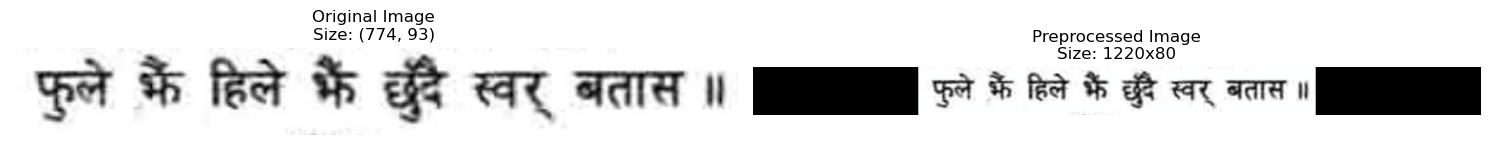

No Transformation module specified
['फुले क#ै हिले #ै छुँदै स्वर् बतास ।']


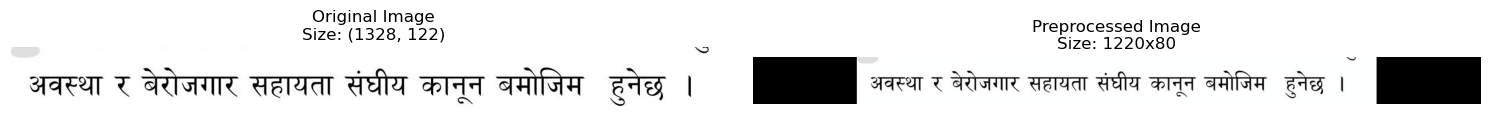

No Transformation module specified
['अवस्था र बेरोजगार सहायता संघीय कानून बमोजिम हुनेछ ।']


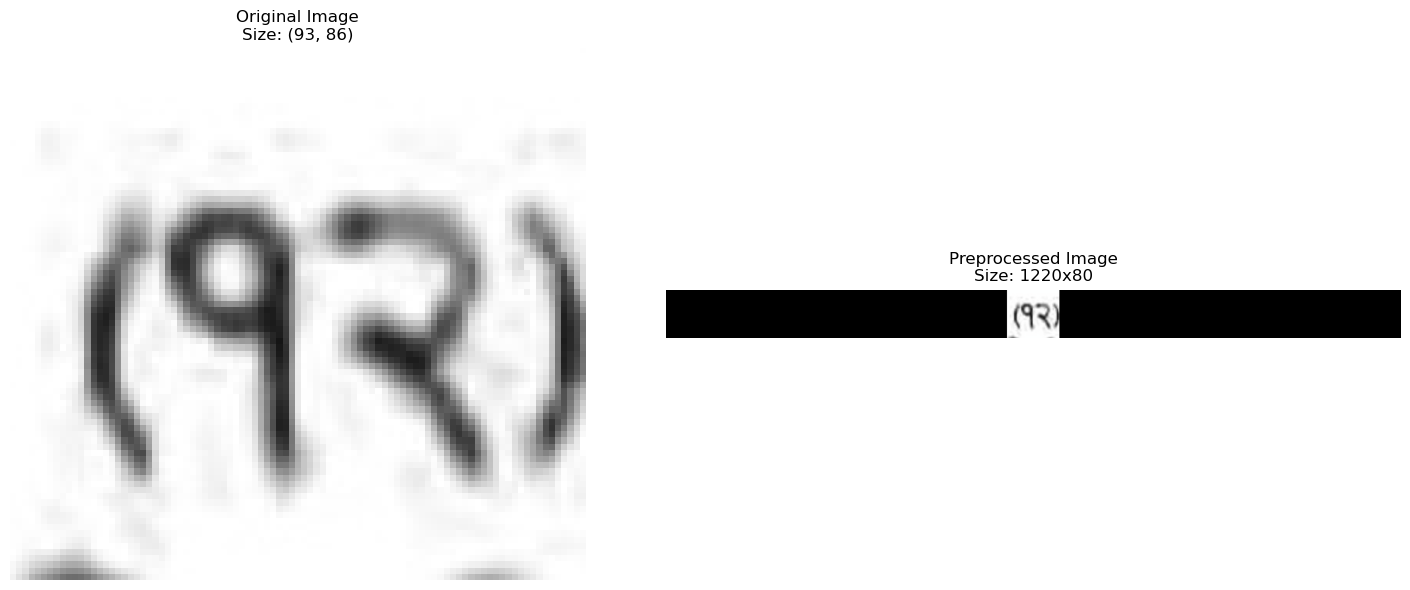

No Transformation module specified
['(१२)']


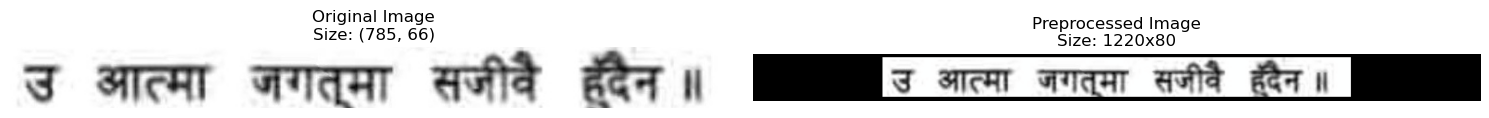

No Transformation module specified
['ज आल्मा जरतमा सजीवै हँदिन ॥[']


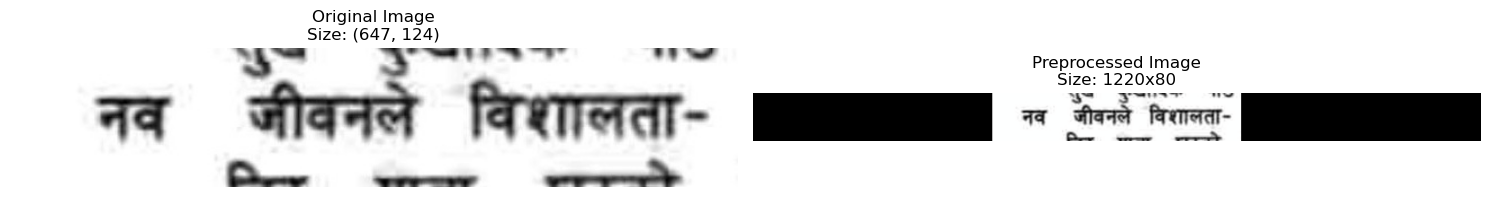

No Transformation module specified
['नव जीवनलै विशालता-']


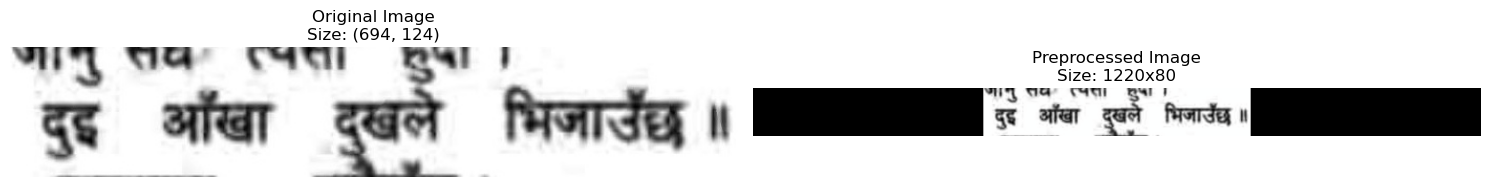

No Transformation module specified
['दु्ु याँखा दुखलनै भिजाउँछ ।।']


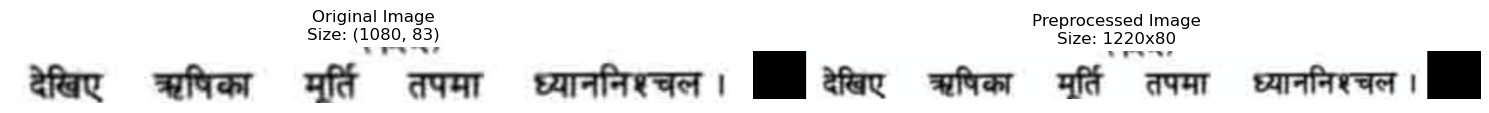

No Transformation module specified
['दैखिए ज्षिक मति तपमा ध्याननिशचल ।']


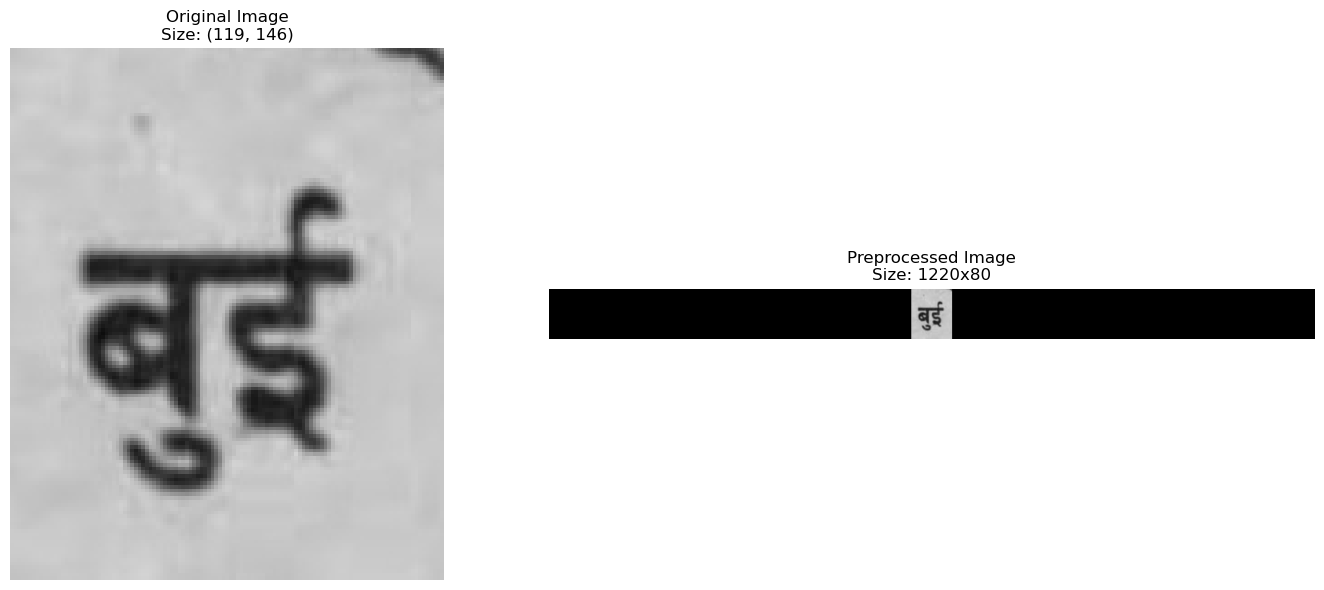

No Transformation module specified
['बुई']


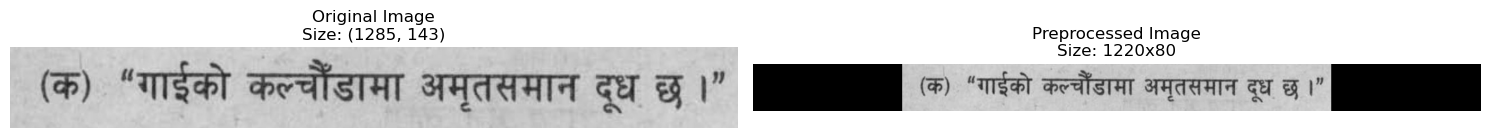

No Transformation module specified
['(क) “गाईको कल्चौँडामा अमृतसमान दूध छ ।”']


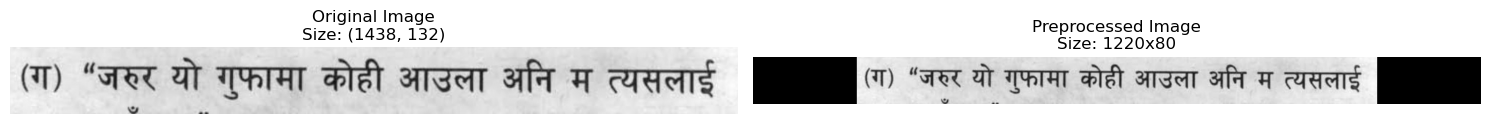

No Transformation module specified
['(ग) “जरुर यो गुफामा कोही आउला अनि म त्यसलाई']


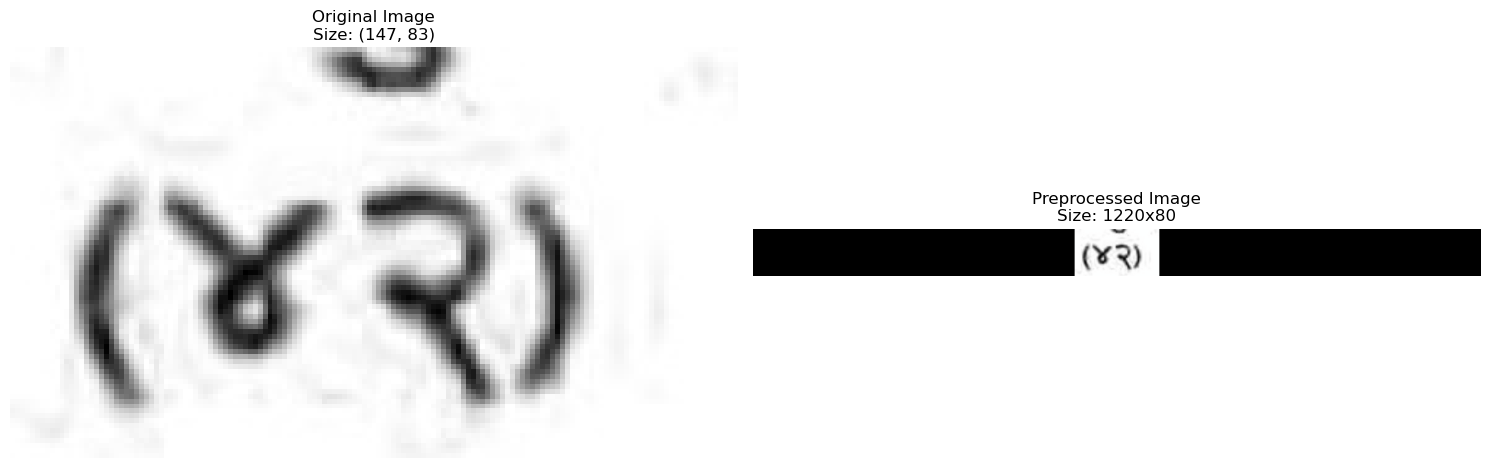

No Transformation module specified
['(४ २)']


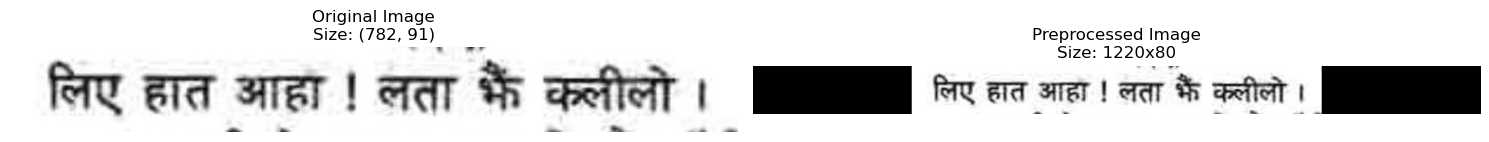

No Transformation module specified
['लिए हत्त आहो ! लता #ैं ््लीलो ।']


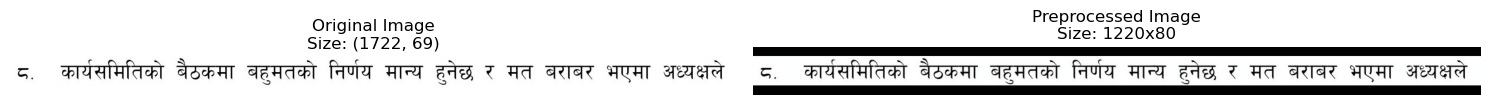

No Transformation module specified
['ड. कार्यसा्मिातिको बैठकमा बहुमतको निर्णय मान्य हुनेछ र मत बराबर भएमा अध्यक्षले']


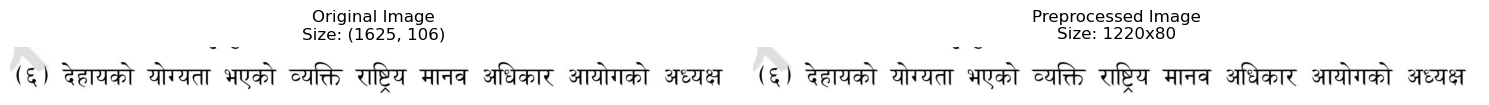

No Transformation module specified
['(६) देहायको योग्यता भएको व्यक्ति राष्ट्रिय मानव अधिकार आयोगको अध्यक्ष']


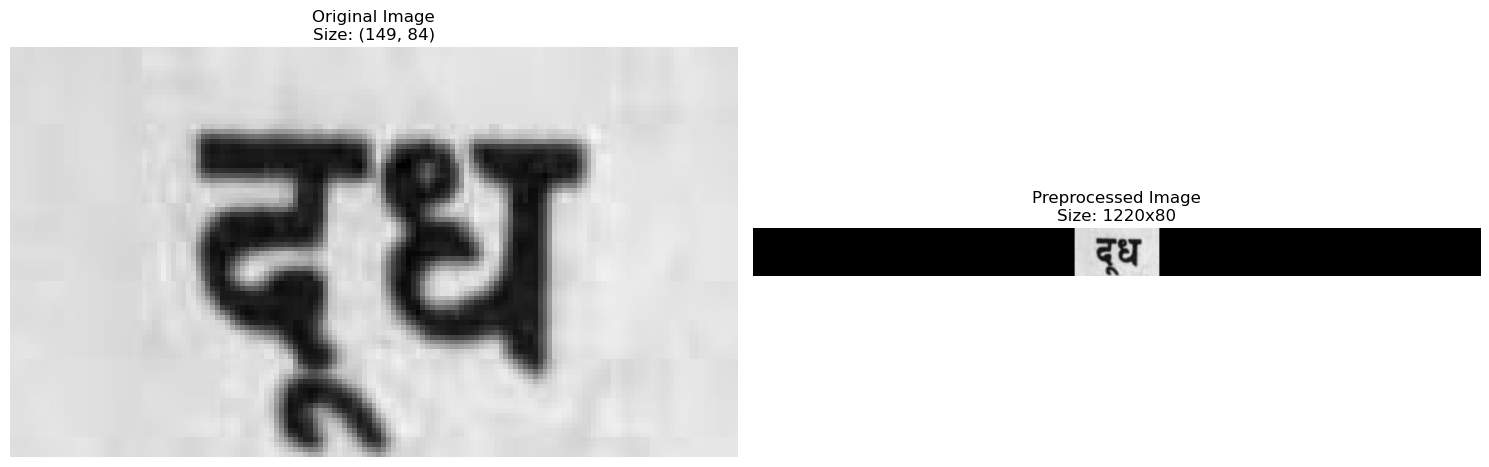

No Transformation module specified
['दूध']


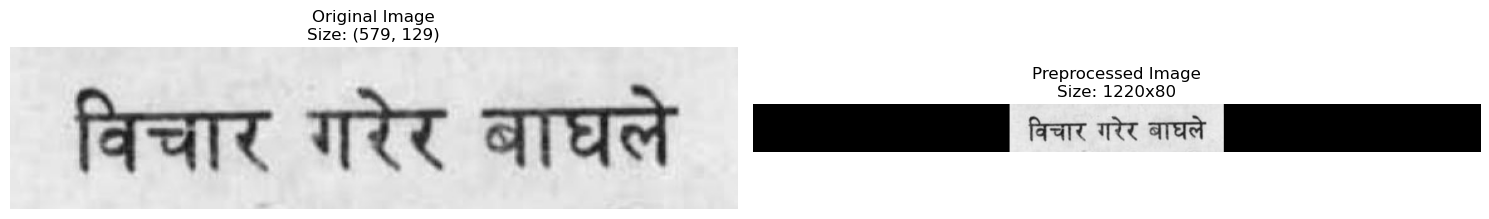

No Transformation module specified
['विचार गरेर बाघले']


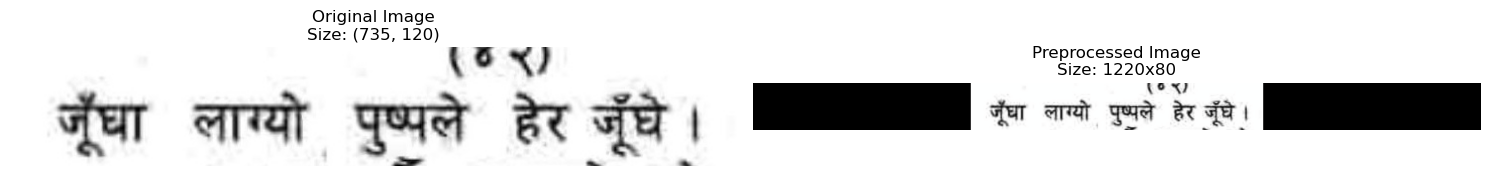

No Transformation module specified
['जूँषा लाग्यो पुष्पले हेर जूँघे ।']


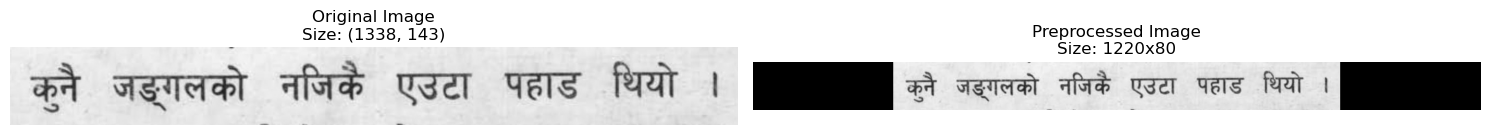

No Transformation module specified
['कुनै जङ्गलको नजिकै एउटा पहाड थियो ।']


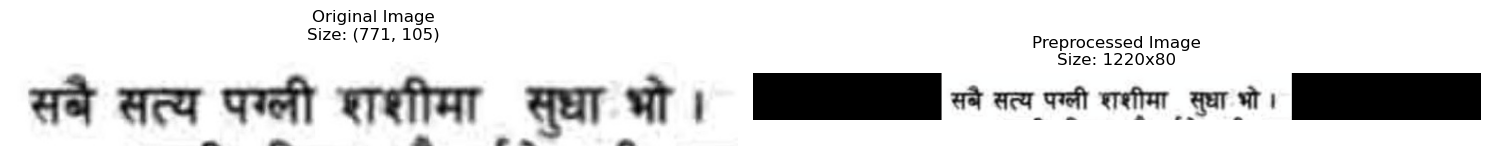

No Transformation module specified
['सबै सत्य पग्ली शशीमा सुधा भो ।']


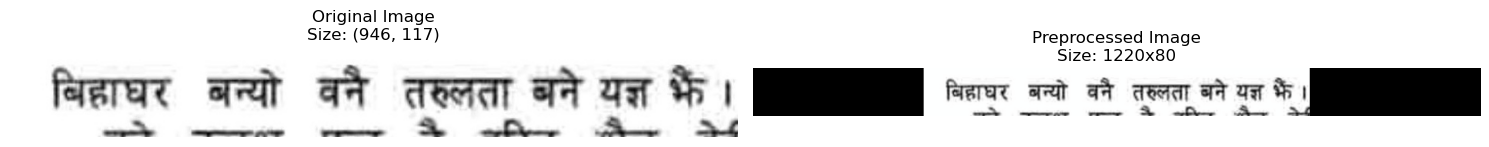

No Transformation module specified
['बिहाघर बत्यो वनै तरुलता बने युज्ञ #ै ।']


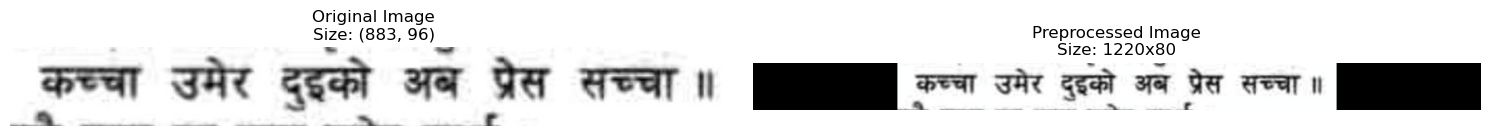

No Transformation module specified
['कच्चा उमेर दुइको अबे प्रेस सच्चा ॥']


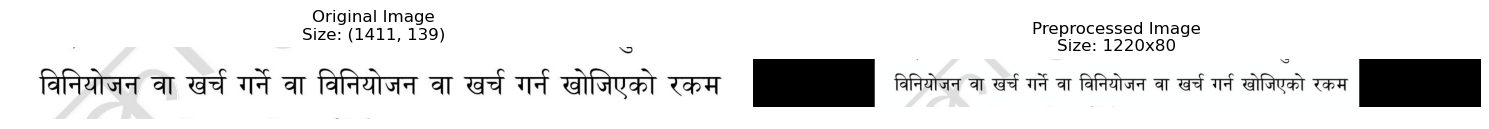

No Transformation module specified
['विनियोजन वा खर्च गर्ने वा विनियोजन वा खर्च गर्न खोजिएको रकम']


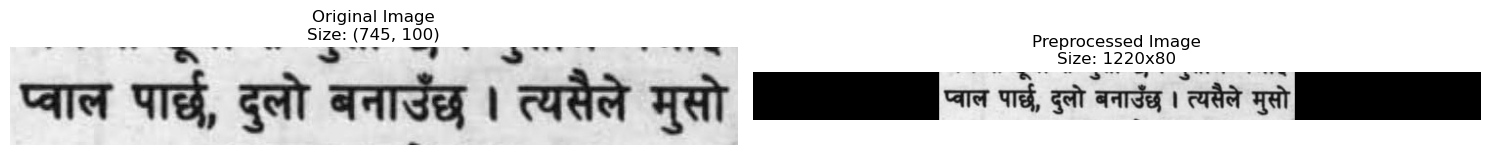

No Transformation module specified
['"प्वाल पार्छ, दुलो बनाउँछ ।त्यसैले मुसो"']


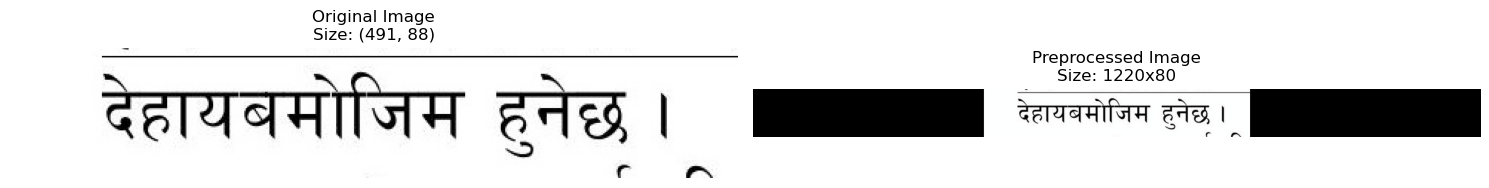

No Transformation module specified
['देहायबमोजिम हुनेछ ।']


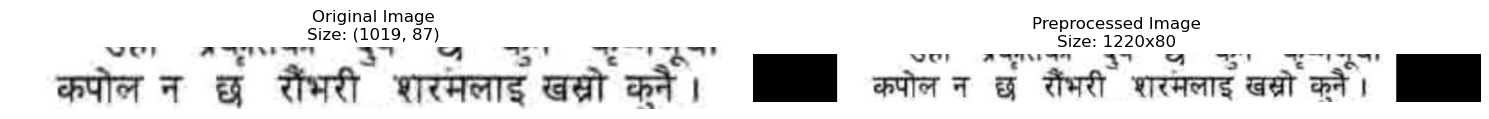

No Transformation module specified
['कपौल न छ  रौभरीरु शेरमलाइड खस्रौ कू्नै:् ।']


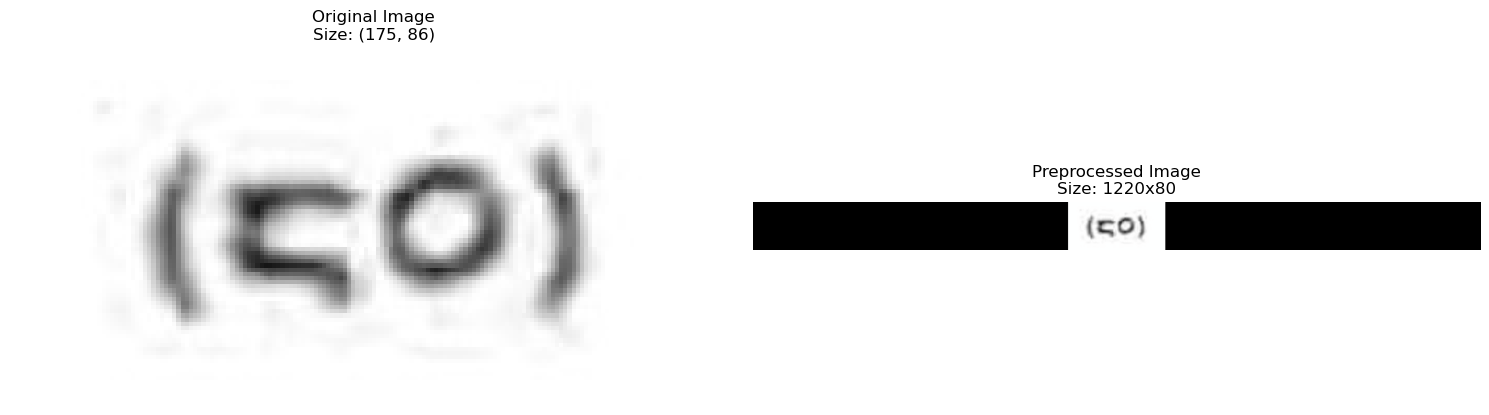

No Transformation module specified
['(छ0)']


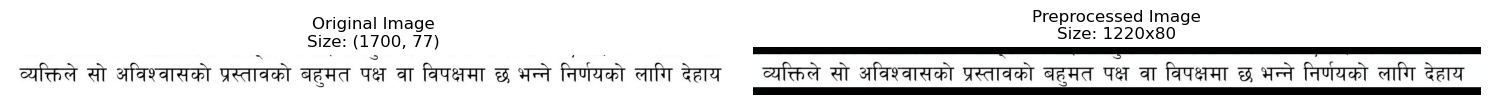

No Transformation module specified
['व्यक्तिले सो अविश्वासको प्रस्तावको बहुमत पक्षिे वा विपक्षमा छ भन्ने निर्णयको लागि देहाय']


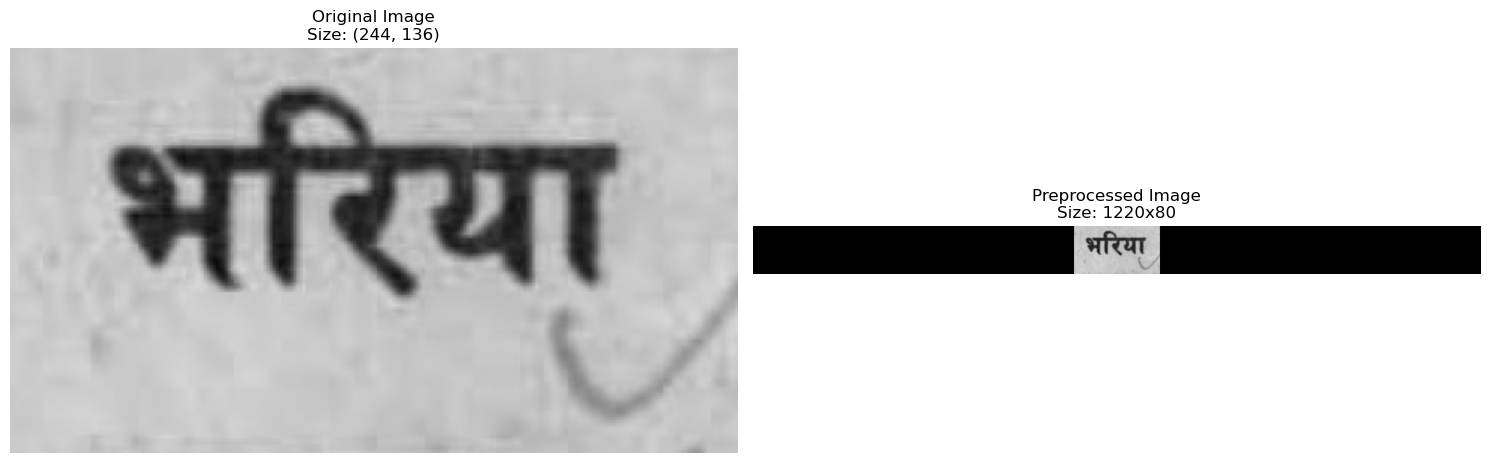

No Transformation module specified
['भरिया']


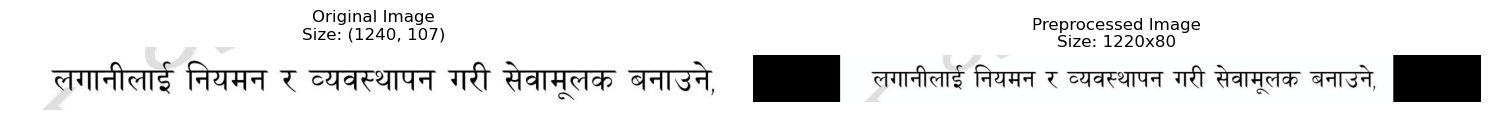

No Transformation module specified
['"लगानीलाई नियमन र व्यवस्थापन गरी सेवामूलक बनाउने,"']


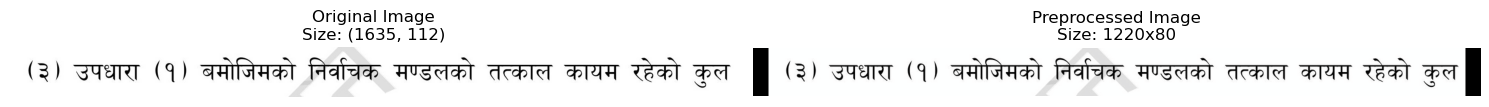

No Transformation module specified
['(३) उपधारा (१) बमोजिमको निर्वाचक मण्डलको तत्काल कायम रहेको कुल']


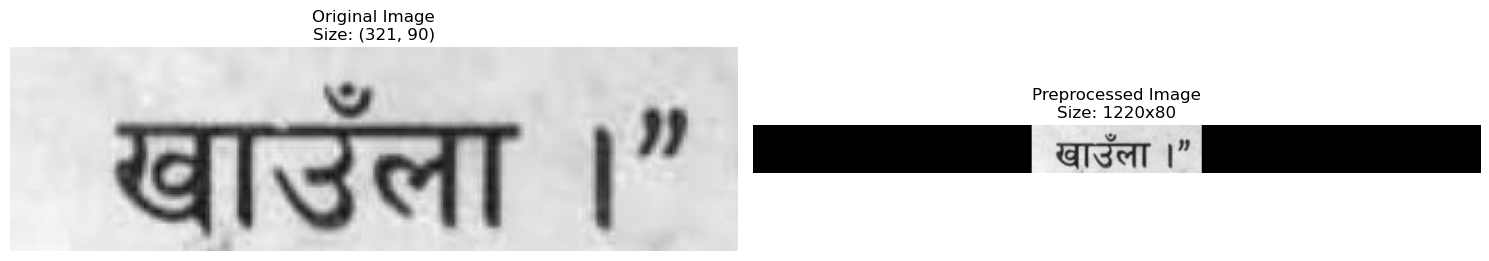

No Transformation module specified
['खाउँला ।)1']


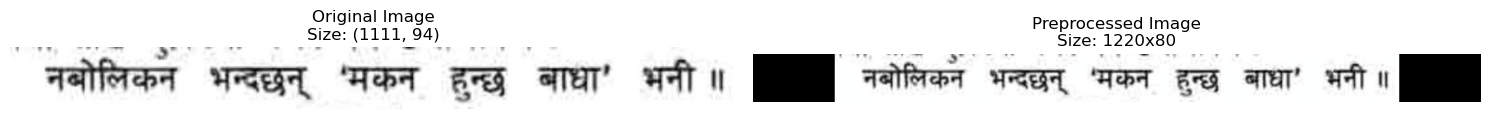

No Transformation module specified
['नबोलिकन भन्दछन् ‘मकन हुन्छ बाधा’ भनी ।']


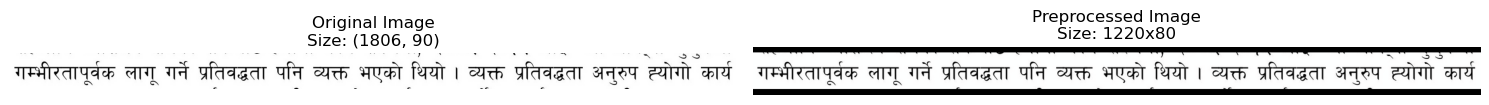

No Transformation module specified
['गम्भीरतापूर्वक लागू गर्ने प्रतिवद्धता पनि व्यक्त भएको थियो । व्यक्त प्रतिवद्धता अनुरुप ह्योगौकार्य']


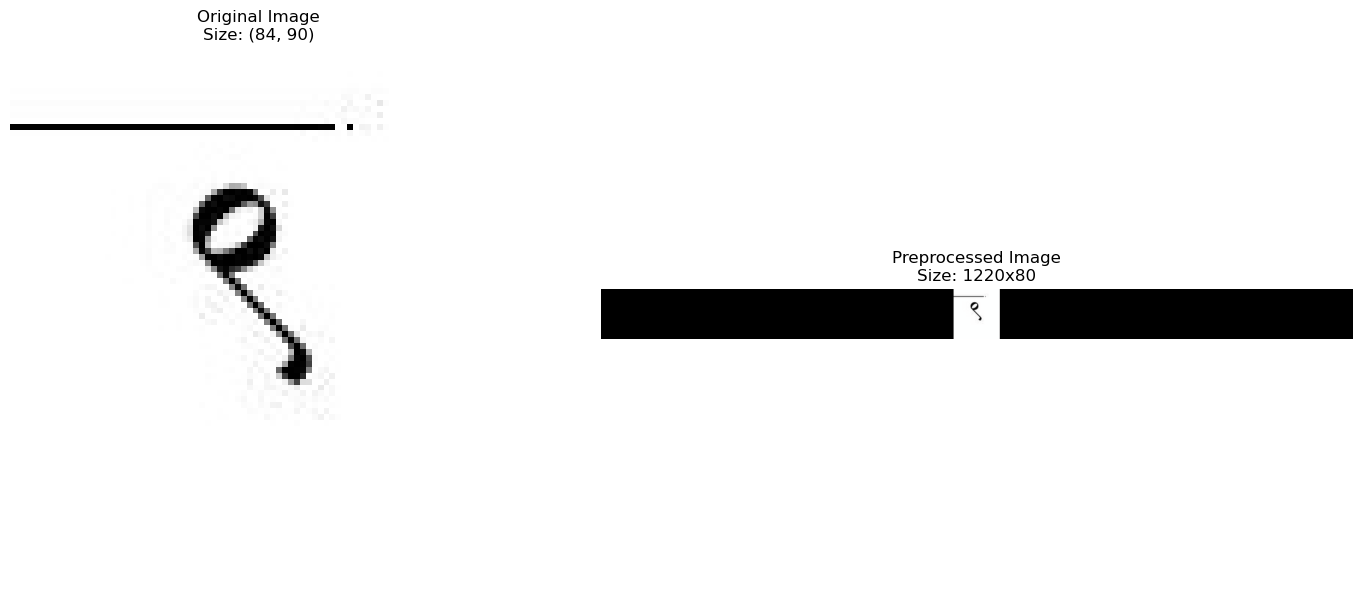

No Transformation module specified
['र']


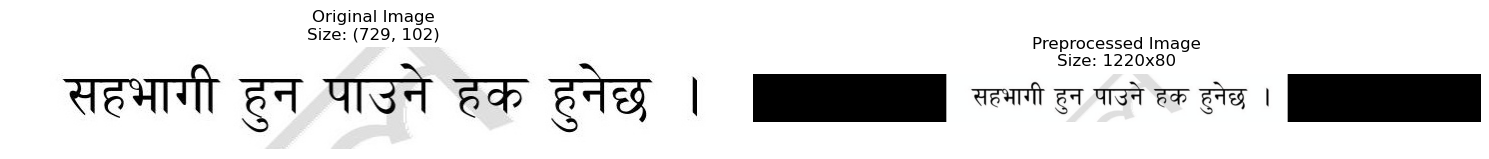

No Transformation module specified
['सहभागी हुन-पाउने हक हुनेछ ।']


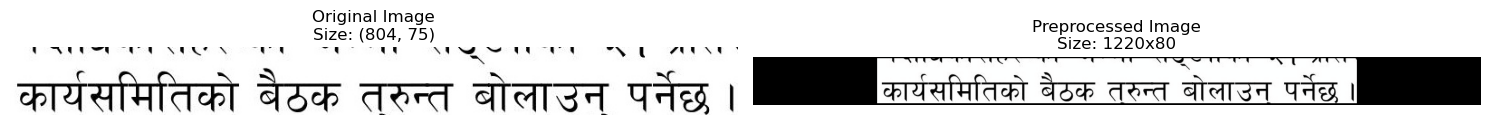

No Transformation module specified
['कार्यसरमितिको बैठक तरुन्त बोलाउन पर्नेछ ।']


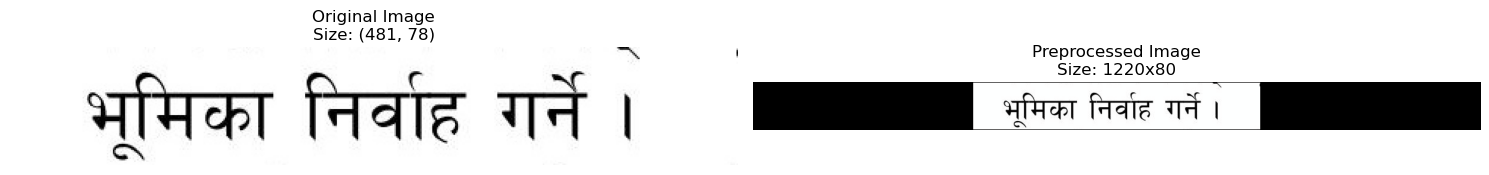

No Transformation module specified
['भूमिका निर्वाह गर्ने ।']


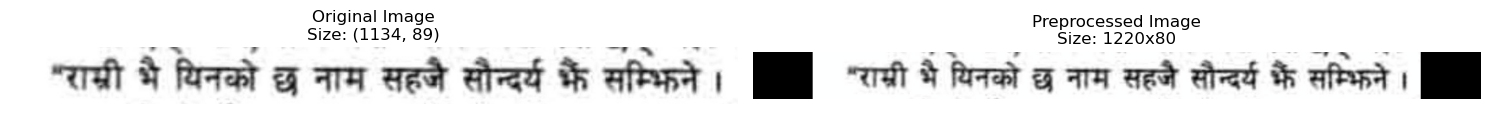

No Transformation module specified
['‘राम्री नै यिनको छ नाम सहजै सौन्दर्य #ै सम्भिने ।']


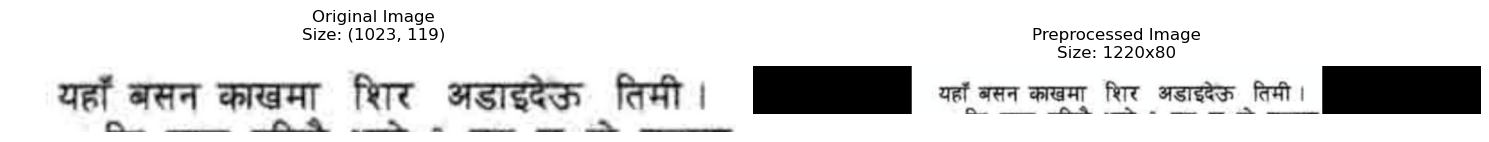

No Transformation module specified
['यहाँ बसन काखमा शिर अडाइदेऊ तिमी ।']


In [ ]:
def inference_crnn_single_image(model, converter, image_path, config):
    
    image_tensor = preprocess_crnn_image(image_path, config)
    image_tensor = image_tensor.to(device)
    batch_size = image_tensor.size(0)
    text_for_pred = torch.LongTensor(batch_size, config.batch_max_length).fill_(0).to(device)
    with torch.no_grad():
        preds = model(image_tensor, text_for_pred)
        
        # Greedy decoding for CTC
        preds_size = torch.IntTensor([preds.size(1)] * batch_size)
        _, preds_index = preds.max(2)
        preds_index = preds_index.view(-1)
        preds_str = converter.decode_greedy(preds_index.data, preds_size.data)
        #preds_str = converter.decode_beamsearch(preds, beamWidth=4)

    #preds_prob = F.softmax(preds, dim=2)
    #preds_max_prob, _ = preds_prob.max(dim=2)
 

    return preds_str
 

all_entries = os.listdir("crops")
files_only = [os.path.join("crops", entry) for entry in all_entries if os.path.isfile(os.path.join("crops", entry))]

for index, string in enumerate(files_only):
    if index == 100:
        break
    visualize_crnn_preprocessing(string, config)
    model, converter = load_crnn_model("models/iter_60000.pth",config)
    print(inference_crnn_single_image(model,converter, string,config))